In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import plotly.express as px
import time
import datetime
from datetime import timedelta
from itertools import groupby
from itertools import compress
from operator import truediv


import import_ipynb
from utils_common import *
from config import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.font_manager as fm
font_chinese = fm.FontProperties(fname='./STFANGSO.ttf')

importing Jupyter notebook from utils_common.ipynb


In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# migration data from Baidu Qianxi
# crawlers are in the folder ./baidu_qx
_N2P_PATH_ = './baidu_qx/n2province_rank.csv' # scrapy crawl n2province_rank -o n2province_rank.csv
_P2P_PATH_ = './baidu_qx/p2province_rank.csv' ###### scrapy crawl p2province_rank -o p2province_rank.csv
# travel size index: national
_NIndex_PATH_ = './baidu_qx/nhistory_curve.csv' # scrapy crawl nhistory_curve -o nhistory_curve.csv
# travel size index: provincial
_Index_PATH_ = './baidu_qx/history_curve.csv' ####### scrapy crawl history_curve -o history_curve.csv
# internal flow: city
_IF_PATH_ = './baidu_qx/internal_flow.csv' ####### scrapy crawl internal_flow -o internal_flow.csv
# # Where to save the figures
_Figure_PATH_ = './figures/'

In [3]:
#### update on December 2020
_P2P_PATH_ = './baidu_qx_new/p2province_rank.csv'
_Index_PATH_ = './baidu_qx_new/history_curve.csv'
_IF_PATH_ = './baidu_qx_new/internal_flow.csv'

In [4]:
# 迁徙规模指数：全国为总体迁徙规模，不区分迁入或迁出；城市级区分迁入或迁出
# Get the travel size index: national (does not distinguish between move in and move out)
def load_NIndex_raw():
    raw = pd.read_csv(_NIndex_PATH_)
    data = raw[raw.inOrout == 'move_in']
    data = data[['date', 'value']]
    rename_dict = {'date': 'update_date',
                    'value': 'value',
                  }
    data = data.rename(columns = rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    return data

# 迁徙规模指数：反映迁入或迁出人口规模，省或城市间可横向对比
# Get the travel size index: provincial (does distinguish between move in and move out)
def load_Index_raw():
    raw = pd.read_csv(_Index_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'province_name': 'province_name',
                    'value': 'value',
                  }
    data = raw.rename(columns = rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name', 'province_name_en', 'value']
    data = data[new_col]
    # remove Tibet, Hongkong, and Macau
    data = data[data['province_name_en'] != 'Tibet']
    data = data[data['province_name_en'] != '香港']
    data = data[data['province_name_en'] != 'Macau']
    data = data[data['province_name_en'] != '台湾省']
    data = data.reset_index(drop = True)
    return data

# Get the travel size ratio: from nation to province or from province to nation
# examples:
# 01月01日， 全国热门迁入地（目的地）是：广东省，迁入人口数量占全国迁入人口总量的13.67%
# 01月01日， 全国热门迁出地（出发地）是：广东省，迁出人口数量占全国迁出人口总量的14.98% 
def load_N2P_raw():
    raw = pd.read_csv(_N2P_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'province_name': 'province_name',
                   'value': 'ratio',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    # the ratio is a percentage
    data['value'] = data.apply(lambda row: data_NIndex[data_NIndex.update_date == row.update_date].value.tolist()[0]*row.ratio/100, axis=1)
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name', 'province_name_en', 'value', 'ratio']
    data = data[new_col]
    # remove Tibet, Hongkong, and Macau
    data = data[data['province_name_en'] != 'Tibet']
    data = data[data['province_name_en'] != '香港']
    data = data[data['province_name_en'] != 'Macau']
    data = data.reset_index(drop = True)
    # display some basic information
    print('Last update: ', data['update_date'].max())
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

# Get the travel size ratio: from province to province
# examples:
# 01月01日，迁入北京人口主要来源地为：河北省，占北京迁入人口总量的50.40%
# 01月01日，北京迁出人口主要目的地为：河北省，占北京迁出人口总量的46.19% 
def load_P2P_raw():
    raw = pd.read_csv(_P2P_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'inOrout_province_name': 'province_name_io',
                   'province_name': 'province_name',
                   'value': 'ratio'
                  }
    data = raw.rename(columns = rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date
   # remove Tibet, Hongkong, and Macau
    data = data[data['province_name'] != '西藏自治区']
    data = data[data['province_name_io'] != '西藏自治区']
    data = data[data['province_name'] != '香港']
    data = data[data['province_name_io'] != '香港']
    data = data[data['province_name'] != '澳门']
    data = data[data['province_name_io'] != '澳门']
    data = data[data['province_name'] != '台湾省']
    data = data[data['province_name_io'] != '台湾省']
    data = data.reset_index(drop = True)
    # there are two methods to calculate the travel size value:
    # 1. using national travel size index and n2p travel size ratio
    # 2. using provincial travel size index and p2p travel size ratio
    # method 1 has severe leakage problem (which has been commented below)
    # method 2 is more preferred
    #data['nvalue'] = data.apply(lambda row: data_N2P[(data_N2P.update_date == row.update_date) & (data_N2P.direction == row.direction) & (data_N2P.province_name == row.province_name)].value.tolist()[0]*row.ratio/100, axis=1)
    data['value'] = data.apply(lambda row: data_Index[(data_Index.update_date == row.update_date) & (data_Index.direction == row.direction) & (data_Index.province_name == row.province_name)].value.tolist()[0]*row.ratio/100, axis=1)
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name_io', 'province_name', 'province_name_en', 'value', 'nvalue', 'ratio']
    new_col = ['update_date', 'direction', 'province_name_io', 'province_name', 'province_name_en', 'value', 'ratio']
    data = data[new_col]
    data = data.sort_values(by = ['update_date', 'direction', 'province_name_io', 'province_name'])
    data = data.reset_index(drop = True)
    
    print('Last update: ', data['update_date'].max())
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

# Compare method 1 and method 2
# Figure out whether the indexs are consistent and whether there exists any data leakage
# temp = data_P2P
def consistency_P2P(temp):
    provinces = data_Index.province_name.drop_duplicates().tolist()
    #nerror_list = []
    error_list = []
    for i in range(0, len(provinces)):
        for j in range(i+1,len(provinces)):
            p, q = provinces[i], provinces[j]
            temp_in = temp[(temp.direction == 'move_in') & (temp.province_name == p) & (temp.province_name_io == q)]
            temp_out = temp[(temp.direction == 'move_out') & (temp.province_name == q) & (temp.province_name_io == p)]
            #nerror = list(map(truediv, temp_in.nvalue.tolist(), temp_out.nvalue.tolist()))
            #nerror = sum(nerror)/temp_in.shape[0]
            error = list(map(truediv, temp_in.value.tolist(), temp_out.value.tolist()))
            error = sum(error)/temp_in.shape[0]
            #if abs(nerror - 1) > 5e-2:
                #print(p, q, nerror)
            if abs(error - 1) > 20e-2:
                print(p, q, error)
            #nerror_list.append(nerror)
            error_list.append(error)
    return error_list # nerror_list, 

# The conclusion is:
# Choose value instead of nvalue 
# Remove 西藏自治区 # Pay attention to 新疆维吾尔自治区 宁夏回族自治区 青海省

# Create the P2P migration network
def network_P2P(temp):
    data = pd.DataFrame(columns=['update_date', 'source', 'target', 'value'])
    data['update_date'] = temp.update_date
    data['source'] = temp.apply(lambda row: row.province_name_io if row.direction == 'move_in' else row.province_name, axis=1)
    data['target'] = temp.apply(lambda row: row.province_name if row.direction == 'move_in' else row.province_name_io, axis=1)
    data['value'] = temp.value
    #data = data[(data.source!='西藏自治区') & (data.target!='西藏自治区')] # remove
    # take the average (for every edge, we have two weights, one from move in and the other from move out)
    data = data.groupby(['update_date', 'source', 'target']).mean().reset_index() 
    data = add_en_location(data, tag = 'network')
    new_col = ['update_date', 'source', 'source_en', 'target', 'target_en', 'value']
    data = data[new_col]
    data.to_csv(r'./data/data_network_P2P.csv', index = False)
    return data

In [5]:
# Get the internal flow data
def load_IF_raw():
    # know which province a city belongs to via their zip codes
    def from_city_to_province(row):
        city_zipcode = [k for k,v in city_dict.items() if v == row.city_name][0]
        province_zipcode = city_zipcode[0:2] + '0000'
        province_name = province_dict[province_zipcode]
        return province_name
    raw = pd.read_csv(_IF_PATH_)
    rename_dict = {'date': 'update_date','value': 'ratio'}
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date 
    data['province_name'] = data.apply(lambda row: from_city_to_province(row), axis = 1)
    # do not include Hongkong, Macau, Taiwan and Tibet
    data = data[~data.province_name.isin(['香港','澳门','台湾省', '西藏自治区'])]
    # add english name
    data['province_name_en'] = data.apply(lambda row: names_province[names_province_cn.index(row.province_name)], axis=1)
    data['population'] = data.apply(lambda row: city_population_dict[row.city_name], axis = 1)
    data['value'] = data.apply(lambda row: row.ratio*row.population/100, axis = 1)
    # summing up to the provincial level
    data_province = data.groupby(['update_date', 'province_name'])["population", "value"].apply(lambda x : x.sum()).reset_index()
    # n stands for normalization
    data_province['n_value'] = data_province.apply (lambda row: row.value/row.population*100, axis=1)
    data_province = add_en_location(data_province, tag = 'province')
    new_col = ['update_date', 'province_name', 'province_name_en', 'population', 'value', 'n_value']
    data_province = data_province[new_col]
    data_province = data_province.sort_values(by = ['update_date', 'province_name_en'])
    data = data.sort_values(by = ['update_date', 'province_name_en', 'population'], na_position='last')
    data = data.reset_index(drop=True)
    data_province = data_province.reset_index(drop=True)
    data_nation = data_province.groupby(['update_date'])["population", "value"].apply(lambda x : x.sum()).reset_index()
    data_nation['n_value'] = data_nation.apply (lambda row: row.value/row.population*100, axis=1)
    return data, data_province, data_nation


In [6]:
# Compress warnings: everyone will be tired of warnings (pretend that they do not exist...)
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")
# Plot the migration index: national, provincial (move in), and provincial (move out)
def figure_inter_single(df, fs, subject = 'China'):
    df = df[df['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df = df[df['update_date'] <= datetime.date(int(2020),int(3),int(10))]
    df = df.reset_index(drop = True)
    if subject == 'China': # sum of provincial migration index
        df = df.groupby('update_date')['value'].sum()
        df = df.reset_index()
    elif subject == 'Hubei (move in)':
        df = df[(df['direction'] == 'move_in') & (df['province_name_en'] == 'Hubei')]
        df = df.reset_index(drop = True)
    elif subject == 'Hubei (move out)':
        df = df[(df['direction'] == 'move_out') & (df['province_name_en'] == 'Hubei')]
        df = df.reset_index(drop = True)
        
    timespan = (max(df.update_date) - min(df.update_date)).days + 1
    # before the quarantine
    T = (datetime.date(int(2020),int(1),int(21)) - min(df.update_date)).days + 1
    # during the quarantine
    TT = (datetime.date(int(2020),int(1),int(31)) - min(df.update_date)).days + 1
    TTT = (datetime.date(int(2020),int(2),int(21)) - min(df.update_date)).days + 1
    
    first_list = [True]*T + [False]*(timespan - T)
    second_list = [False]*TT + [True]*(TTT - TT) + [False]*(timespan - TTT)
    first_mean = np.mean(np.multiply(df.value.tolist(), first_list))*timespan/T
    second_mean = np.mean(np.multiply(df.value.tolist(), second_list))*timespan/(TTT - TT)
    first_index = [first_mean]*timespan
    second_index = [second_mean]*timespan
    
    fig = plt.figure(figsize = (12, 5))
    ax = plt.subplot(111)
    sns.set_style('whitegrid')
    palette = plt.get_cmap('bone_r')
    y_min, y_max = np.round(min(df.value), 1)*0.95, np.round(max(df.value), 1)*1.05
    ax.scatter(df['update_date'], df['value'],marker = 'o', 
               color = [rgb2hex(palette(temp/y_max + 0.15)) for temp in df['value'].tolist()],
               label = None)
    ax.plot(df['update_date'], df['value'], linewidth = 2, color = palette(0.5), label = None)
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.plot(list(compress(df['update_date'], first_list)), list(compress(first_index, first_list)), 
            linewidth = 2, color = palette(first_mean/y_max + 0.05), label = 'average plateau')
    ax.plot(list(compress(df['update_date'], second_list)), list(compress(second_index, second_list)), 
            linewidth = 2, color = palette(second_mean/y_max + 0.05), label = 'lockdown plateau')
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # matplotlib.patch.Patch properties
    props_first = dict(boxstyle = 'round', facecolor = palette(first_mean/y_max + 0.05), alpha = 0.5)
    props_second = dict(boxstyle = 'round', facecolor = palette(second_mean/y_max + 0.05), alpha = 0.5)
    
    if y_min <= 0.5:
        ax.set_ylim(-0.5, y_max)
    else:
        ax.set_ylim(y_min, y_max)
    
    shift = 0.3
    
    # place two text boxes
    ax.text(0/timespan + 0.03, (first_mean - y_min)/(y_max - y_min) - shift,
            'average plateau: ' + str(round(first_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_first)
    ax.text(TT/timespan + 0.03, (second_mean - y_min)/(y_max - y_min) + shift,  # - 0.25, - 0.1
            'average plateau: ' + str(round(second_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_second)
    if subject == 'China':
        ax.set_title(subject + ': inter-province mobility (' + str(round(second_mean/first_mean*100, 2)) + '%)', fontsize = fs + 2) 
    else:
        ax.set_title(subject.split("(")[0] + ': inter-province mobility ' + '(' + subject.split("(")[1] + ' (' + str(round(second_mean/first_mean*100, 2)) + '%)', fontsize = fs + 2) 
    ax.set_xlabel('Date', fontsize = fs)
    ax.set_ylabel('Index', fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    subject = subject.replace("(","")
    subject = subject.replace(")","")
    fig.savefig(_Figure_PATH_ + 'figures_china/' + subject.replace(" ", "_") + '_inter.png', dpi = 400)

In [7]:
# From the above conclusion: method 1 🌝 method 2 🌚
# Get the travel size index: national
#data_NIndex = load_NIndex_raw() 
#list_0 = data_NIndex.value.tolist()
# Get the travel size index: provincial
data_Index = load_Index_raw()
# 2019-01-12 to 2019-04-12, 2020-01-01 to 2020-03-15, 2020-09-22 to 2020-12-02
# Verify that there is hardly any data leakage
list_1 = data_Index[(data_Index.direction == 'move_in')].groupby('update_date').agg('sum').value.tolist()
list_2 = data_Index[(data_Index.direction == 'move_out')].groupby('update_date').agg('sum').value.tolist()
#list(map(truediv, list_0, list_1)) # agree? no
#list(map(truediv, list_1, list_2)) # agree? yes

In [8]:
# Find the time interval
# Spring Festival: 
# Year 2019 Tuesday, February 5 (2019-02-05)
# Year 2020 Saturday, January 25 (2020-01-25)
# Chunyun:
# https://zh.wikipedia.org/wiki/%E6%98%A5%E8%BF%90
# Year 2019 2019-01-21 to 2019-03-01
# Year 2020 2020-01-10 to 2020-02-18
date_2019 = data_Index[data_Index['update_date'] <= datetime.date(2019, 12, 31)]['update_date'] # Year 2019
date_2020 = data_Index[data_Index['update_date'] > datetime.date(2019, 12, 31)]['update_date'] # Year 2020
print('year 2019: begin ', min(date_2019), ' end ', max(date_2019), ' spring festival 2019-02-05',
      '\n', 'year 2020: begin ', min(date_2020), ' end ', max(date_2020), ' spring festival 2020-01-25', sep='')

year 2019: begin 2019-01-12 end 2019-04-12 spring festival 2019-02-05
year 2020: begin 2020-01-01 end 2020-12-02 spring festival 2020-01-25


In [9]:
data_slice = data_Index[data_Index['update_date'] >= datetime.date(int(2020),int(1),int(1))]
#data_slice.groupby('update_date')['value'].sum()

In [10]:
data_slice = data_Index[data_Index['province_name_en'] == 'Hubei']
data_slice = data_slice[data_slice['update_date'] >= datetime.date(int(2020),int(1),int(1))]
data_slice = data_slice[data_slice['direction'] == 'move_out']
data_slice

update_date direction province_name province_name_en     value
6517  2020-01-01  move_out           湖北省            Hubei  2.561285
6518  2020-01-02  move_out           湖北省            Hubei  3.126535
6519  2020-01-03  move_out           湖北省            Hubei  4.256258
6520  2020-01-04  move_out           湖北省            Hubei  4.882032
6521  2020-01-05  move_out           湖北省            Hubei  4.583336
...          ...       ...           ...              ...       ...
6659  2020-11-28  move_out           湖北省            Hubei  2.570519
6660  2020-11-29  move_out           湖北省            Hubei  2.121228
6661  2020-11-30  move_out           湖北省            Hubei  2.483881
6662  2020-12-01  move_out           湖北省            Hubei  2.375503
6663  2020-12-02  move_out           湖北省            Hubei  2.250763

[147 rows x 5 columns]

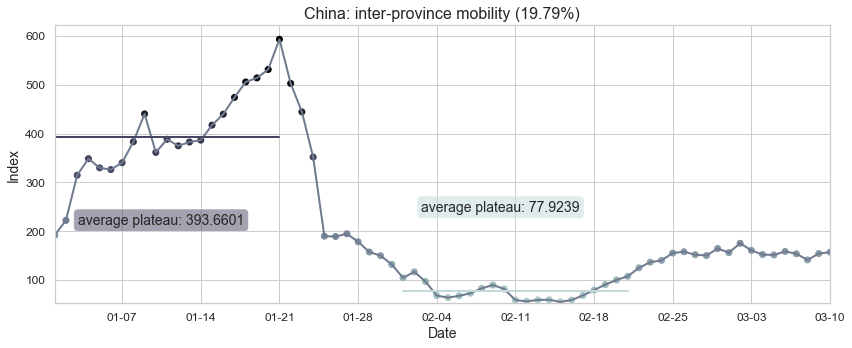

In [308]:
# national migration index
figure_inter_single(data_Index, fs = 14, subject = 'China')

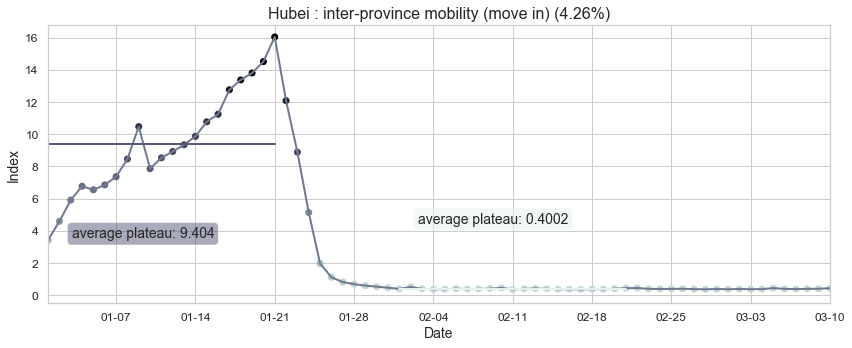

In [309]:
# provincial migration index (move in)
figure_inter_single(data_Index, fs = 14, subject = 'Hubei (move in)')

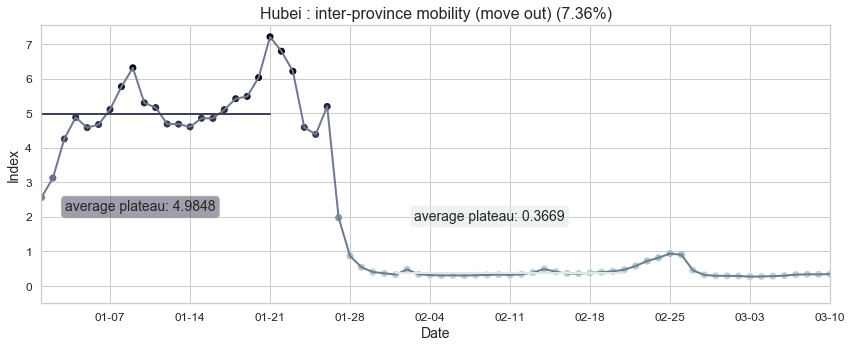

In [388]:
# provincial migration index (move out)
figure_inter_single(data_Index, fs = 14, subject = 'Hubei (move out)')

In [14]:
def figure_inter(df_Index, direction, date_initial, date_tr, ms, fsize, fs, title, country):
    df = df_Index[(df_Index['direction'] == direction) & (df_Index['update_date'] >= date_initial) & (df_Index['update_date'] <= date_tr)].copy()
    df = df.sort_values(by=['update_date', 'province_name_en'])
    df = df.reset_index(drop=True)
    df_Beijing = df[df['province_name_en'] == 'Beijing']
    df_Beijing = df_Beijing.reset_index(drop=True)
    df_Hubei = df[df['province_name_en'] == 'Hubei']
    df_Hubei = df_Hubei.reset_index(drop=True)
    # last year
    df_last = df_Index[(df_Index['direction'] == direction) & (df_Index['update_date'] >= date_sp_2019 - date_sp_2020 + date_initial) & (df_Index['update_date'] <= date_sp_2019 - date_sp_2020 + date_tr)].copy()
    df_last = df_last.sort_values(by=['update_date', 'province_name_en'])
    df_last = df_last.reset_index(drop=True)
    df_Beijing_last = df_last[df_last['province_name_en'] == 'Beijing']
    df_Beijing_last = df_Beijing_last.reset_index(drop=True)
    df_Hubei_last = df_last[df_last['province_name_en'] == 'Hubei']
    df_Hubei_last = df_Hubei_last.reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style('whitegrid')
    palette = tealrose
    palette = [item for item in palette for j in range(int(len(names_province)/len(palette)) + 1)]
    for i, key in enumerate(names_province):
        grp = df[df['province_name_en'] == key].copy()
        grp = grp.reset_index(drop = True)
        grp_last = df_last[df_last['province_name_en'] == key].copy()
        grp_last = grp_last.reset_index(drop = True)
        #corr = grp['value'].corr(grp_last['value'])
        if key == 'Hubei':
            ax.plot(grp['update_date'], grp['value'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key)
        else:
            corr = grp['value'].corr(df_Hubei['value'])
            corr_last = grp_last['value'].corr(df_Hubei_last['value'])
            ax.plot(grp['update_date'], grp['value'], linewidth = 1.5, color = palette[i], label = key  + ': ' + str(round(corr, 2)) + ' (' + str(round(corr_last, 2)) + ')')
            
    plt.legend(loc='upper center', ncol = 4, fancybox = True, handlelength = 1, fontsize = fs - 5)
    ax.set_xlabel("Date", fontsize = fs - 2)
    ax.set_ylabel("Value", fontsize = fs - 2)
    ax.set_title('China: inter-province mobility' + ' (' + direction.replace("_", " ") + ')', fontsize = fs)
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 5)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 5)
    
    print(date_sp_2019 - date_sp_2020 + date_initial)
    print(date_sp_2019 - date_sp_2020 + date_tr)
    
#     # plot
#     fig = plt.figure(figsize=fsize)
#     sns.set_style("whitegrid")
#     palette = tealrose
#     palette = [item for item in palette for j in range(int(len(names_province)/len(palette)) + 1)]
#     ax1 = fig.add_subplot(211)
#     for i, key in enumerate(names_province):
#         grp = df[df['province_name_en'] == key].copy()
#         grp = grp.reset_index(drop = True)
#         if key!='Hubei':
#             corr = grp['value'].corr(df_Hubei['value'])
#             ax1.plot(grp['update_date'], grp['value'], linewidth = 1.5, color = palette[i], label = key  + ': ' + str(round(corr, 2)))
#         else:
#             ax1.plot(grp['update_date'], grp['value'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key)
#     plt.legend(loc='upper center', ncol = 6, fancybox = True, handlelength = 1, fontsize = fs - 6)
#     #ax1.set_xlabel("Date", fontsize = fs - 4)
#     ax1.set_ylabel("Value", fontsize = fs - 4)
#     ax1.set_title('Year 2020', fontsize = fs - 2)
#     ax1.set_xlim(min(df.update_date), max(df.update_date))
#     ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
#     # last year
#     ax2 = fig.add_subplot(212)
#     for j, key in enumerate(names_province):
#         grp_last = df_last[df_last['province_name_en'] == key].copy()
#         grp_last = grp_last.reset_index(drop = True)
#         if key!='Hubei':
#             corr_last = grp_last['value'].corr(df_Hubei_last['value'])
#             ax2.plot(grp_last['update_date'], grp_last['value'], linewidth = 1.5, color = palette[j], label = key  + ': ' + str(round(corr_last, 2)))
#         else:
#             ax2.plot(grp_last['update_date'], grp_last['value'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key)
#     plt.legend(loc='upper center', ncol = 6, fancybox = True, handlelength = 1, fontsize = fs - 6)
#     ax2.set_xlabel("Date", fontsize = fs - 4)
#     ax2.set_ylabel("Value", fontsize = fs - 4)
#     ax2.set_title('Year 2019', fontsize = fs - 2)
#     ax2.set_xlim(min(df_last.update_date), max(df_last.update_date))
#     ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
#     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
#     # align labels
#     ax1.get_yaxis().set_label_coords(-0.03,0.5)
#     ax2.get_yaxis().set_label_coords(-0.03,0.5)
    
#     fig.suptitle('China: inter-province mobility' + ' (' + direction.replace("_", " ") + ')', fontsize = fs + 2, y = 1.02)
    

2019-01-18
2019-03-22


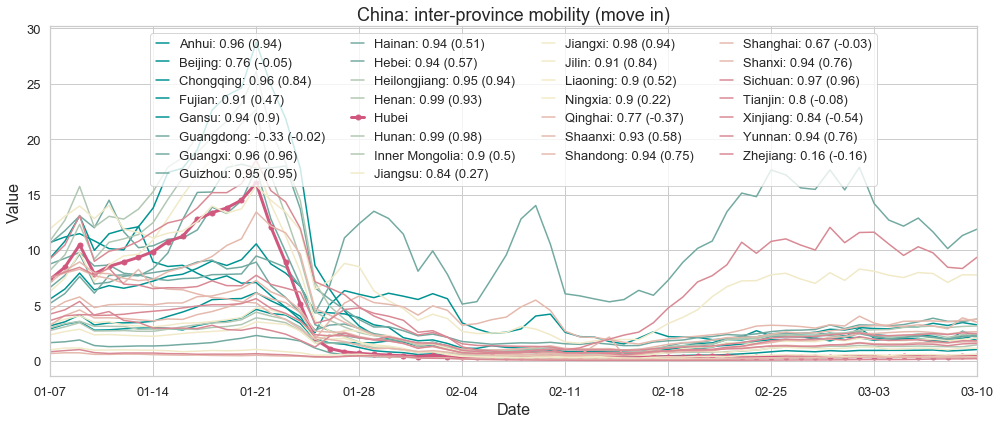

In [16]:
figure_inter(data_Index, 'move_in', datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
                      ms = 5, fsize = (14, 6), fs = 18, title = None, country = 'China')

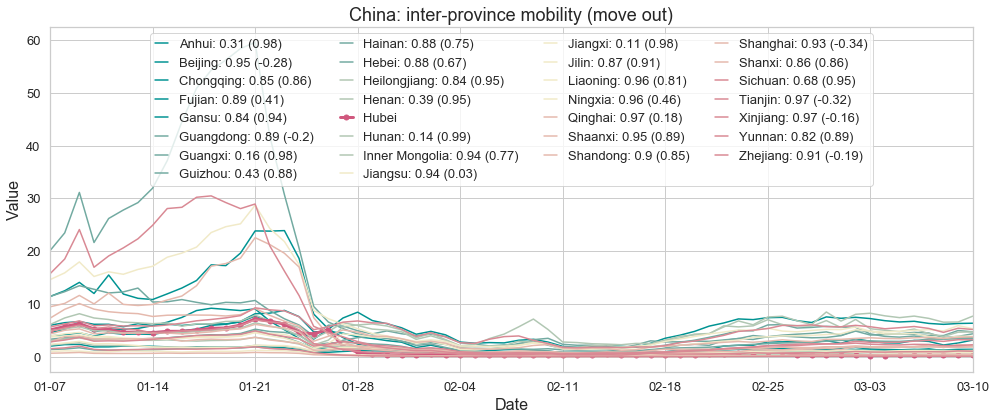

In [391]:
figure_inter(data_Index, 'move_out', datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
                      ms = 5, fsize = (14, 6), fs = 18, title = None, country = 'China')

In [392]:
def figure_inter(df_Index, date_initial, date_tr, ncol = 3, ms = 2, 
                 fsize = (5, 2), fs = 10, title = None, country = 'China'):
    
    df = df_Index[(df_Index['update_date'] >= date_initial) & (df_Index['update_date'] <= date_tr)].copy()
    df = df.sort_values(by=['update_date', 'direction', 'province_name_en'])
    df = df.reset_index(drop=True)
    
    m = len(names_province)
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    palette = tealrose
    palette_o = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    a, b = 0.6, 0.6
    # direction: move_in
    for i, province in enumerate(names_province):
        
        ######## move in ########
        df_single = df[(df['province_name_en'] == province) & (df['direction'] == 'move_in')].copy()
        df_single = df_single.reset_index(drop=True)
        
        #axes[ix].plot(df_single['update_date'], df_single['value'], linewidth = 2, marker = 'o', ms = ms, 
                      #color = palette[1], alpha = 1, label = (lambda x: None if x > 0 else 'move in')(i)) 
        
        ix = np.unravel_index(i, axes.shape)
        
        # differenc response levels
        # before level 1
        df_single_0 = df_single[df_single['update_date'] < provincial_response_1_dict[province]].copy()
        axes[ix].plot(df_single_0['update_date'], df_single_0['value'],
                linewidth = 2, color = palette_o[1], alpha = a, label = None)
        axes[ix].fill_between(df_single_0['update_date'], df_single_0['value'], 0,
                                color = palette_o[1], alpha = a, label = 'no response')
        
        # level 1
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['value'],
                linewidth = 2, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['value'], 0,
                                color = tealrose[-2], alpha = a, label = 'class 1')
        else: # with level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single[(df_single['update_date'] >= provincial_response_2_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['value'],
                linewidth = 2, color = tealrose[-2], alpha = a, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['value'], 0,
                                color = tealrose[-2], alpha = a, label = 'class 1')
            axes[ix].plot(df_single_2['update_date'], df_single_2['value'],
                linewidth = 2, color = tealrose[3], alpha = a, label = None)
            axes[ix].fill_between(df_single_2['update_date'], df_single_2['value'], 0,
                                color = tealrose[3], alpha = a, label = 'class 2')
        # level 3
        df_single_3 = df_single[df_single['update_date'] >= provincial_response_3_dict[province]].copy()
        axes[ix].plot(df_single_3['update_date'], df_single_3['value'],
                linewidth = 2, color = tealrose[1], alpha = a, label = None)
        axes[ix].fill_between(df_single_3['update_date'], df_single_3['value'], 0,
                             color = tealrose[1], alpha = a, label = 'class 3')
    
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Value", fontsize = fs - 2)
        if i == 1:
            #hand, label = axes[ix].get_legend_handles_labels()
            patch_0 = mpatches.Patch(color = palette_o[1], label = 'no response')
            patch_1 = mpatches.Patch(color = palette[-2], label = 'level 1')
            patch_2 = mpatches.Patch(color = palette[3], label = 'level 2')
            patch_3 = mpatches.Patch(color = palette[1], label = 'level 3')
            #axes[ix].legend(hand[4:], label[4:], loc='upper center', bbox_to_anchor=(0.5, 1.5), 
                            #ncol = 4, fancybox = True, fontsize = fs - 2)
            axes[ix].legend(handles=[patch_0, patch_1, patch_2, patch_3], loc='upper center', bbox_to_anchor=(0.5, 1.8), 
                            ncol = 4, fancybox = True, fontsize = fs - 2)
            
    
    
        ######## move out ########
        df_single = df[(df['province_name_en'] == province) & (df['direction'] == 'move_out')].copy()
        df_single = df_single.reset_index(drop=True)
        
        
        # differenc response levels
        # before level 1
        df_single_0 = df_single[df_single['update_date'] < provincial_response_1_dict[province]].copy()
        axes[ix].plot(df_single_0['update_date'], df_single_0['value'],
                linewidth = 2, color = palette_o[1], alpha = b, label = None)
        axes[ix].fill_between(df_single_0['update_date'], df_single_0['value'], 0,
                             hatch = '+', color = palette_o[1], alpha = b, label = 'no response')
        
        # level 1
        if provincial_response_2_dict[province] == None: # without level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['value'],
                linewidth = 2, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['value'], 0,
                                 hatch = '+', color = tealrose[-2], alpha = b, label = 'class 1')
        else: # with level 2
            df_single_1 = df_single[(df_single['update_date'] >= provincial_response_1_dict[province]) & (df_single['update_date'] < provincial_response_2_dict[province])].copy()
            df_single_2 = df_single[(df_single['update_date'] >= provincial_response_2_dict[province]) & (df_single['update_date'] < provincial_response_3_dict[province])].copy()
            axes[ix].plot(df_single_1['update_date'], df_single_1['value'],
                linewidth = 2, color = tealrose[-2], alpha = b, label = None)
            axes[ix].fill_between(df_single_1['update_date'], df_single_1['value'], 0,
                                 hatch = '+', color = tealrose[-2], alpha = b, label = 'class 1')
            axes[ix].plot(df_single_2['update_date'], df_single_2['value'],
                linewidth = 2, color = tealrose[3], alpha = b, label = None)
            axes[ix].fill_between(df_single_2['update_date'], df_single_2['value'], 0,
                                 hatch = '+', color = tealrose[3], alpha = b, label = 'class 2')
        # level 3
        df_single_3 = df_single[df_single['update_date'] >= provincial_response_3_dict[province]].copy()
        axes[ix].plot(df_single_3['update_date'], df_single_3['value'],
                linewidth = 2, color = tealrose[1], alpha = b, label = None)
        axes[ix].fill_between(df_single_3['update_date'], df_single_3['value'], 0,
                             hatch = '+', color = tealrose[1], alpha = b, label = 'class 3')
        
        
        if i == 0:
            patch_in = mpatches.Patch(color = palette[-2], fill=False, label = 'move in')
            patch_out = mpatches.Patch(color = palette[-2], fill=False, hatch = '+', label = 'move out')
            axes[ix].legend(handles=[patch_in, patch_out], loc='upper center', 
                            ncol = 2, fancybox = True, fontsize = fs - 2)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)  

        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(date_initial, date_tr)
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    fig.align_ylabels(axes[:, 0])    
    fig.suptitle('China: inter-province mobility', fontsize = fs + 2, y = 1.015)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_inter_province.png', dpi = 400, bbox_inches='tight')   
    
    


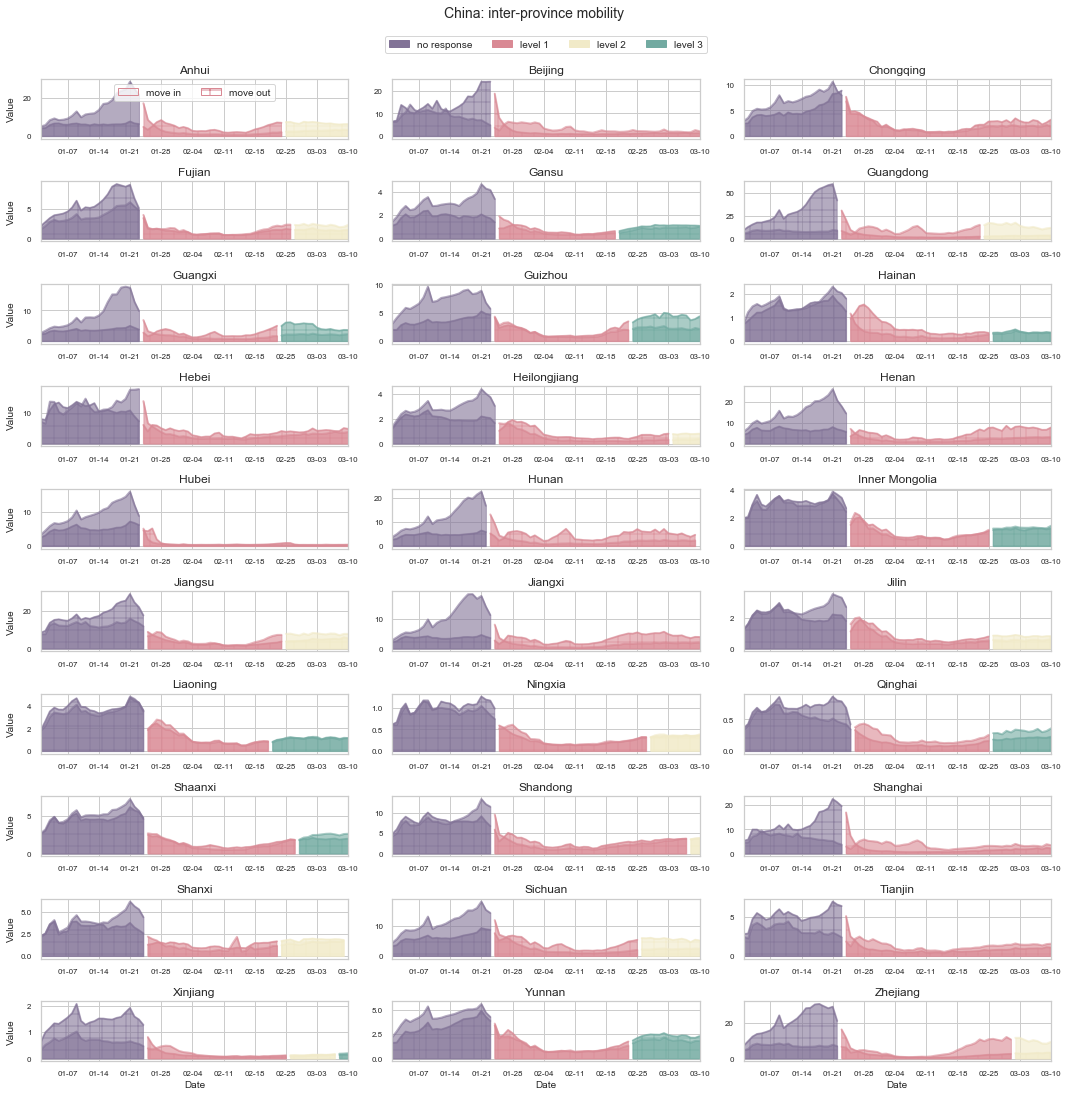

In [393]:
figure_inter(data_Index, datetime.date(int(2020),int(1),int(1)), datetime.date(int(2020),int(3),int(10)), 
             ncol = 3, ms = 2, fsize = (5, 1.5), fs = 12, title = None, country = 'China')

In [316]:
# From the above conclusion: method 1 🌚 method 2 🌝 
# method 1
# Get the travel size ratio: n2p
# examples:
# 01月01日， 全国热门迁入地（目的地）是：广东省，迁入人口数量占全国迁入人口总量的13.67% 
# 2020-01-01	move_in	广东省	Guangdong	13.67
# 01月01日， 全国热门迁出地（出发地）是：广东省，迁出人口数量占全国迁出人口总量的14.98%
# 2020-01-01	move_out	广东省	Guangdong	14.98
#data_N2P = load_N2P_raw()

In [369]:
# method 2
# Get the travel size ratio: p2p
# 01月01日，迁入新疆人口主要来源地为：甘肃省，占新疆迁入人口总量的 14.89%
data_P2P = load_P2P_raw()
# 2020-01-01 to 2020-03-15, 2020-09-22 to 2020-12-02
# the index of province A move in province B (from B to A) should be equal (at least close to) 
# that of province B move out province A (from B to A)
# examples proving the above statement
#temp_in = data_P2P[(data_P2P.direction == 'move_in') & (data_P2P.province_name == '新疆维吾尔自治区') & (data_P2P.province_name_io == '甘肃省')]
#temp_out = data_P2P[(data_P2P.direction == 'move_out') & (data_P2P.province_name == '甘肃省') & (data_P2P.province_name_io == '新疆维吾尔自治区')]
#[(x+y)/2 for x,y in zip(*[temp_in, temp_out])][:10]

Last update:  2020-12-02
Data date range:  2020-01-01 to 2020-12-02
Number of rows in raw data:  255688


In [318]:
data_P2P

update_date direction province_name_io province_name province_name_en  \
0       2020-01-01   move_in              上海市           云南省           Yunnan   
1       2020-01-01   move_in              上海市        内蒙古自治区   Inner Mongolia   
2       2020-01-01   move_in              上海市           北京市          Beijing   
3       2020-01-01   move_in              上海市           吉林省            Jilin   
4       2020-01-01   move_in              上海市           四川省          Sichuan   
5       2020-01-01   move_in              上海市           天津市          Tianjin   
6       2020-01-01   move_in              上海市       宁夏回族自治区          Ningxia   
7       2020-01-01   move_in              上海市           安徽省            Anhui   
8       2020-01-01   move_in              上海市           山东省         Shandong   
9       2020-01-01   move_in              上海市           山西省           Shanxi   
10      2020-01-01   move_in              上海市           广东省        Guangdong   
11      2020-01-01   move_in              上海市       广西壮族自治区          Guangxi   
12      2020-01-01   move_in              上海市      新疆维吾尔自治区         Xinjiang   
13      2020-01-01   move_in              上海市           江苏省          Jiangsu   
14      2020-01-01   move_in              上海市           江西省          Jiangxi   
15      2020-01-01   move_in              上海市           河北省            Hebei   
16      2020-01-01   move_in              上海市           河南省            Henan   
17      2020-01-01   move_in              上海市           浙江省         Zhejiang   
18      2020-01-01   move_in              上海市           海南省           Hainan   
19      2020-01-01   move_in              上海市           湖北省            Hubei   
20      2020-01-01   move_in              上海市           湖南省            Hunan   
21      2020-01-01   move_in              上海市           甘肃省            Gansu   
22      2020-01-01   move_in              上海市           福建省           Fujian   
23      2020-01-01   move_in              上海市           贵州省          Guizhou   
24      2020-01-01   move_in              上海市           辽宁省         Liaoning   
25      2020-01-01   move_in              上海市           重庆市        Chongqing   
26      2020-01-01   move_in              上海市           陕西省          Shaanxi   
27      2020-01-01   move_in              上海市           青海省          Qinghai   
28      2020-01-01   move_in              上海市          黑龙江省     Heilongjiang   
29      2020-01-01   move_in              云南省           上海市         Shanghai   
...            ...       ...              ...           ...              ...   
255658  2020-12-02  move_out              青海省          黑龙江省     Heilongjiang   
255659  2020-12-02  move_out             黑龙江省           上海市         Shanghai   
255660  2020-12-02  move_out             黑龙江省           云南省           Yunnan   
255661  2020-12-02  move_out             黑龙江省        内蒙古自治区   Inner Mongolia   
255662  2020-12-02  move_out             黑龙江省           北京市          Beijing   
255663  2020-12-02  move_out             黑龙江省           吉林省            Jilin   
255664  2020-12-02  move_out             黑龙江省           四川省          Sichuan   
255665  2020-12-02  move_out             黑龙江省           天津市          Tianjin   
255666  2020-12-02  move_out             黑龙江省       宁夏回族自治区          Ningxia   
255667  2020-12-02  move_out             黑龙江省           安徽省            Anhui   
255668  2020-12-02  move_out             黑龙江省           山东省         Shandong   
255669  2020-12-02  move_out             黑龙江省           山西省           Shanxi   
255670  2020-12-02  move_out             黑龙江省           广东省        Guangdong   
255671  2020-12-02  move_out             黑龙江省       广西壮族自治区          Guangxi   
255672  2020-12-02  move_out             黑龙江省      新疆维吾尔自治区         Xinjiang   
255673  2020-12-02  move_out             黑龙江省           江苏省          Jiangsu   
255674  2020-12-02  move_out             黑龙江省           江西省          Jiangxi   
255675  2020-12-02  move_out             黑龙江省           河北省            Hebei   
255676 

In [319]:
data_slice = data_P2P[(data_P2P['update_date'] == datetime.date(int(2020),int(1),int(31)))]
data_slice = data_slice[(data_slice['province_name_en'] == 'Hubei')]
data_slice = data_slice[data_slice['direction'] == 'move_out']
data_slice.sort_values(by = 'ratio', ascending = False)

update_date direction province_name_io province_name province_name_en  \
53698  2020-01-31  move_out              湖南省           湖北省            Hubei   
53581  2020-01-31  move_out              河南省           湖北省            Hubei   
53407  2020-01-31  move_out              广东省           湖北省            Hubei   
53843  2020-01-31  move_out              重庆市           湖北省            Hubei   
53320  2020-01-31  move_out              安徽省           湖北省            Hubei   
53523  2020-01-31  move_out              江西省           湖北省            Hubei   
53872  2020-01-31  move_out              陕西省           湖北省            Hubei   
53233  2020-01-31  move_out              四川省           湖北省            Hubei   
53494  2020-01-31  move_out              江苏省           湖北省            Hubei   
53610  2020-01-31  move_out              浙江省           湖北省            Hubei   
53088  2020-01-31  move_out              上海市           湖北省            Hubei   
53175  2020-01-31  move_out              北京市           湖北省            Hubei   
53756  2020-01-31  move_out              福建省           湖北省            Hubei   
53552  2020-01-31  move_out              河北省           湖北省            Hubei   
53349  2020-01-31  move_out              山东省           湖北省            Hubei   
53436  2020-01-31  move_out          广西壮族自治区           湖北省            Hubei   
53785  2020-01-31  move_out              贵州省           湖北省            Hubei   
53117  2020-01-31  move_out              云南省           湖北省            Hubei   
53378  2020-01-31  move_out              山西省           湖北省            Hubei   
53262  2020-01-31  move_out              天津市           湖北省            Hubei   
53727  2020-01-31  move_out              甘肃省           湖北省            Hubei   
53204  2020-01-31  move_out              吉林省           湖北省            Hubei   
53465  2020-01-31  move_out         新疆维吾尔自治区           湖北省            Hubei   
53901  2020-01-31  move_out              青海省           湖北省            Hubei   
53639  2020-01-31  move_out              海南省           湖北省            Hubei   
53814  2020-01-31  move_out              辽宁省           湖北省            Hubei   
53146  2020-01-31  move_out           内蒙古自治区           湖北省            Hubei   
53930  2020-01-31  move_out             黑龙江省           湖北省            Hubei   
53291  2020-01-31  move_out          宁夏回族自治区           湖北省            Hubei   

          value  ratio  
53698  0.086661  23.57  
53581  0.055776  15.17  
53407  0.053276  14.49  
53843  0.051658  14.05  
53320  0.020480   5.57  
53523  0.020259   5.51  
53872  0.016178   4.40  
53233  0.014450   3.93  
53494  0.009817   2.67  
53610  0.007464   2.03  
53088  0.004375   1.19  
53175  0.003934   1.07  
53756  0.003677   1.00  
53552  0.002831   0.77  
53349  0.002537   0.69  
53436  0.002280   0.62  
53785  0.002059   0.56  
53117  0.001360   0.37  
53378  0.001287   0.35  
53262  0.001287   0.35  
53727  0.001066   0.29  
53204  0.001029   0.28  
53465  0.000662   0.18  
53901  0.000552   0.15  
53639  0.000478   0.13  
53814  0.000441   0.12  
53146  0.000404   0.11  
53930  0.000404   0.11  
53291  0.000368   0.10

In [371]:
error_list = consistency_P2P(data_P2P)

In [321]:
data_P2P.sort_values(by = 'value', ascending = False) # 84.39, 0.01

update_date direction province_name_io province_name province_name_en  \
147405  2020-10-01  move_out              河北省           北京市          Beijing   
146170  2020-10-01   move_in              北京市           河北省            Hebei   
33390   2020-01-20   move_in              广东省       广西壮族自治区          Guangxi   
34289   2020-01-20  move_out          广西壮族自治区           广东省        Guangdong   
32549   2020-01-19  move_out          广西壮族自治区           广东省        Guangdong   
31650   2020-01-19   move_in              广东省       广西壮族自治区          Guangxi   
35130   2020-01-21   move_in              广东省       广西壮族自治区          Guangxi   
36029   2020-01-21  move_out          广西壮族自治区           广东省        Guangdong   
35139   2020-01-21   move_in              广东省           湖南省            Hunan   
36290   2020-01-21  move_out              湖南省           广东省        Guangdong   
33399   2020-01-20   move_in              广东省           湖南省            Hunan   
34550   2020-01-20  move_out              湖南省           广东省        Guangdong   
29910   2020-01-18   move_in              广东省       广西壮族自治区          Guangxi   
30809   2020-01-18  move_out          广西壮族自治区           广东省        Guangdong   
28170   2020-01-17   move_in              广东省       广西壮族自治区          Guangxi   
29069   2020-01-17  move_out          广西壮族自治区           广东省        Guangdong   
29919   2020-01-18   move_in              广东省           湖南省            Hunan   
31070   2020-01-18  move_out              湖南省           广东省        Guangdong   
32810   2020-01-19  move_out              湖南省           广东省        Guangdong   
31659   2020-01-19   move_in              广东省           湖南省            Hunan   
147183  2020-10-01  move_out              安徽省           江苏省          Jiangsu   
146482  2020-10-01   move_in              江苏省           安徽省            Anhui   
29330   2020-01-17  move_out              湖南省           广东省        Guangdong   
28179   2020-01-17   move_in              广东省           湖南省            Hunan   
26430   2020-01-16   move_in              广东省       广西壮族自治区          Guangxi   
27329   2020-01-16  move_out          广西壮族自治区           广东省        Guangdong   
36870   2020-01-22   move_in              广东省       广西壮族自治区          Guangxi   
37769   2020-01-22  move_out          广西壮族自治区           广东省        Guangdong   
35915   2020-01-21  move_out              安徽省           江苏省          Jiangsu   
35214   2020-01-21   move_in              江苏省           安徽省            Anhui   
...            ...       ...              ...           ...              ...   
76761   2020-02-14   move_in          宁夏回族自治区           吉林省            Jilin   
79882   2020-02-15  move_out              贵州省           青海省          Qinghai   
73283   2020-02-12   move_in          宁夏回族自治区           吉林省            Jilin   
73892   2020-02-12   move_in              青海省           吉林省            Jilin   
75631   2020-02-13   move_in              青海省           吉林省            Jilin   
75023   2020-02-13   move_in          宁夏回族自治区           吉林省            Jilin   
77981   2020-02-14  move_out              海南省       宁夏回族自治区          Ningxia   
77545   2020-02-14  move_out              吉林省       宁夏回族自治区          Ningxia   
74089   2020-02-12  move_out              吉林省           青海省          Qinghai   
75806   2020-02-13  move_out              吉林省       宁夏回族自治区          Ningxia   
76126   2020-02-13  move_out              江西省       宁夏回族自治区          Ningxia   
76532   2020-02-13  move_out             黑龙江省       宁夏回族自治区          Ningxia   
68465   2020-02-09   move_in              湖北省           青海省          Qinghai   
74068   2020-02-12  move_out              吉林省       宁夏回族自治区          Ningxia   
68871   2020-02-09  move_out              吉林省           青海省          Qinghai   
79862   2020-02-15  move_out              贵州省       宁夏回族自治区          Ningxia   
130407  2020-03-15  move_out             黑龙江省           青海省          Qinghai   
84512   2020-02-18  move_out              吉林省           青海省          Qinghai   
84744  

In [372]:
data_network_P2P = network_P2P(data_P2P)

In [326]:
df_slice =  data_network_P2P[data_network_P2P['update_date'] == datetime.date(int(2020),int(1),int(31))]
df_slice = df_slice[df_slice['source_en'] == 'Zhejiang']
df_slice.sort_values(by = ['source_en', 'target_en'])

update_date source source_en    target       target_en     value
26630  2020-01-31    浙江省  Zhejiang       安徽省           Anhui  0.140842
26625  2020-01-31    浙江省  Zhejiang       北京市         Beijing  0.061303
26647  2020-01-31    浙江省  Zhejiang       重庆市       Chongqing  0.027764
26644  2020-01-31    浙江省  Zhejiang       福建省          Fujian  0.102513
26643  2020-01-31    浙江省  Zhejiang       甘肃省           Gansu  0.018305
26633  2020-01-31    浙江省  Zhejiang       广东省       Guangdong  0.153650
26634  2020-01-31    浙江省  Zhejiang   广西壮族自治区         Guangxi  0.032048
26645  2020-01-31    浙江省  Zhejiang       贵州省         Guizhou  0.061247
26640  2020-01-31    浙江省  Zhejiang       海南省          Hainan  0.008641
26638  2020-01-31    浙江省  Zhejiang       河北省           Hebei  0.025765
26650  2020-01-31    浙江省  Zhejiang      黑龙江省    Heilongjiang  0.019407
26639  2020-01-31    浙江省  Zhejiang       河南省           Henan  0.075540
26641  2020-01-31    浙江省  Zhejiang       湖北省           Hubei  0.008212
26642  2020-01-31    浙江省  Zhejiang       湖南省           Hunan  0.054876
26624  2020-01-31    浙江省  Zhejiang    内蒙古自治区  Inner Mongolia  0.006302
26636  2020-01-31    浙江省  Zhejiang       江苏省         Jiangsu  0.296323
26637  2020-01-31    浙江省  Zhejiang       江西省         Jiangxi  0.099085
26626  2020-01-31    浙江省  Zhejiang       吉林省           Jilin  0.016021
26646  2020-01-31    浙江省  Zhejiang       辽宁省        Liaoning  0.018877
26629  2020-01-31    浙江省  Zhejiang   宁夏回族自治区         Ningxia  0.004760
26649  2020-01-31    浙江省  Zhejiang       青海省         Qinghai  0.003801
26648  2020-01-31    浙江省  Zhejiang       陕西省         Shaanxi  0.031547
26631  2020-01-31    浙江省  Zhejiang       山东省        Shandong  0.058320
26622  2020-01-31    浙江省  Zhejiang       上海市        Shanghai  0.433362
26632  2020-01-31    浙江省  Zhejiang       山西省          Shanxi  0.013923
26627  2020-01-31    浙江省  Zhejiang       四川省         Sichuan  0.057937
26628  2020-01-31    浙江省  Zhejiang       天津市         Tianjin  0.015387
26635  2020-01-31    浙江省  Zhejiang  新疆维吾尔自治区        Xinjiang  0.006502
26623  2020-01-31    浙江省  Zhejiang       云南省          Yunnan  0.040584

In [327]:
# Chunyun 2020: from January 10 to February 18
# the travel size of Chunyun from wikipedia
# 14.76 unit = 亿人次 https://zh.wikipedia.org/wiki/%E6%98%A5%E8%BF%90
# the travel size of Chunyun from Baidu Qianxi
# compare these numbers to deduce the unit of data from Baidu Qianxi
# 10603 unit = 十万人次
#nation_migration = {"20200110":438.973668,"20200111":481.0020084,"20200112":446.3765172,"20200113":436.1630004,"20200114":412.6136436,"20200115":431.4138732,"20200116":450.4974408,"20200117":479.9456712,"20200118":529.5260304,"20200119":525.4227648,"20200120":542.3144724,"20200121":621.2109996,"20200122":580.6973268,"20200123":551.6447328,"20200124":448.30989,"20200125":261.5466672,"20200126":287.4244176,"20200127":264.7354104,"20200128":225.8917632,"20200129":192.6017028,"20200130":183.7748412,"20200131":153.6096312,"20200201":130.643928,"20200202":142.4592036,"20200203":117.190152,"20200204":85.9585284,"20200205":81.3802464,"20200206":81.188244,"20200207":85.798116,"20200208":94.7500092,"20200209":111.1956336,"20200210":100.9839312,"20200211":74.7511092,"20200212":71.3811852,"20200213":73.1563812,"20200214":73.4141556,"20200215":70.6802436,"20200216":73.5190992,"20200217":92.2017168,"20200218":96.6906396}
#sum(nation_migration.values())

In [374]:
# 9134 unit = 十万人次
data_P2P_chunyun = data_P2P[(data_P2P.update_date >= datetime.date(int(2020),int(1),int(10))) & (data_P2P.update_date <= datetime.date(int(2020),int(2),int(18)))]
chunyun_in, chunyun_out = sum(data_P2P_chunyun[data_P2P_chunyun.direction == 'move_in'].value), sum(data_P2P_chunyun[data_P2P_chunyun.direction == 'move_out'].value)
chunyun_in, chunyun_out, chunyun_in + chunyun_out

(4560.595407920167, 4560.548774240533, 9121.1441821607)

In [329]:
# What the minimal value would be if we remove 宁夏回族自治区，新疆维吾尔自治区，甘肃省 and 青海省 from the data set
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='宁夏回族自治区') & (data_P2P.province_name!='宁夏回族自治区')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='新疆维吾尔自治区') & (data_P2P.province_name!='新疆维吾尔自治区')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='甘肃省') & (data_P2P.province_name!='甘肃省')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='青海省') & (data_P2P.province_name!='青海省')]
#data_P2P_x.loc[data_P2P_x.value.idxmin()]

In [373]:
# city-level, province-level, nation-level
data_if_city, data_if, data_if_nation = load_IF_raw()
# 2019-01-12 to 2019-03-28, 2020-01-01 to 2020-05-07, 2020-09-15 to 2020-11-12

In [331]:
data_slice = data_if_city[data_if_city['update_date'] == datetime.date(int(2020),int(1),int(31))]
data_slice = data_slice[data_slice['province_name'] == '湖北省']
data_slice.sort_values(by = 'population', ascending = False)

city_name update_date   ratio province_name province_name_en  \
38215         武汉市  2020-01-31  0.6906           湖北省            Hubei   
38214         黄冈市  2020-01-31  1.9718           湖北省            Hubei   
38213         襄阳市  2020-01-31  1.6411           湖北省            Hubei   
38212         荆州市  2020-01-31  2.0037           湖北省            Hubei   
38211         孝感市  2020-01-31  1.6138           湖北省            Hubei   
38210         宜昌市  2020-01-31  1.6354           湖北省            Hubei   
38209         十堰市  2020-01-31  1.5553           湖北省            Hubei   
38208  恩施土家族苗族自治州  2020-01-31  2.6656           湖北省            Hubei   
38207         荆门市  2020-01-31  1.7281           湖北省            Hubei   
38206         咸宁市  2020-01-31  1.8751           湖北省            Hubei   
38205         黄石市  2020-01-31  1.8662           湖北省            Hubei   
38204         随州市  2020-01-31  1.5080           湖北省            Hubei   
38203         仙桃市  2020-01-31  1.7345           湖北省            Hubei   
38202         天门市  2020-01-31  2.0323           湖北省            Hubei   
38201         鄂州市  2020-01-31  1.2986           湖北省            Hubei   
38200       神农架林区  2020-01-31  1.8703           湖北省            Hubei   
38216         潜江市  2020-01-31  1.4266           湖北省            Hubei   

       population        value  
38215  10892900.0   75226.3674  
38214   6341000.0  125031.8380  
38213   5654000.0   92787.7940  
38212   5641700.0  113042.7429  
38211   4915000.0   79318.2700  
38210   4135600.0   67633.6024  
38209   3418000.0   53160.1540  
38208   3361000.0   89590.8160  
38207   2901500.0   50140.8215  
38206   2535100.0   47535.6601  
38205   2470500.0   46104.4710  
38204   2210500.0   33334.3400  
38203   1544500.0   26789.3525  
38202   1283500.0   26084.5705  
38201   1076900.0   13984.6234  
38200     76800.0    1436.3904  
38216         NaN          NaN

In [332]:
data_if_city.to_csv(r'./data/data_bdqx_if_city.csv', index = False)
data_if.to_csv(r'./data/data_bdqx_if_province.csv', index = False)

In [333]:
# Find the time interval
# Spring Festival: 
# Year 2019 Tuesday, February 5 (2019-02-05)
# Year 2020 Saturday, January 25 (2019-01-25)
date_2019 = data_if_city[data_if_city['update_date'] <= datetime.date(2019, 12, 31)]['update_date'] # Year 2019
date_2020 = data_if_city[data_if_city['update_date'] > datetime.date(2019, 12, 31)]['update_date'] # Year 2020
print('year 2019: begin ', min(date_2019), ' end ', max(date_2019), ' spring festival 2019-02-05',
      '\n', 'year 2020: begin ', min(date_2020), ' end ', max(date_2020), ' spring festival 2020-01-25', sep='')

year 2019: begin 2019-01-12 end 2019-03-28 spring festival 2019-02-05
year 2020: begin 2020-01-01 end 2020-11-12 spring festival 2020-01-25


In [394]:
# Plot the internal flow index: national, provincial (Hubei), and city level (Wuhan)
def figure_intra_single(df, subject, fs = 12):
    df = df[df['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df = df[df['update_date'] <= datetime.date(int(2020),int(3),int(10))]
    df = df.reset_index(drop = True)
    fig = plt.figure(figsize = (12, 5))
    ax = plt.subplot(111)
    sns.set_style('whitegrid')
    timespan = (max(df.update_date) - min(df.update_date)).days + 1
    T = (datetime.date(int(2020),int(1),int(21)) - min(df.update_date)).days + 1
    TT = (datetime.date(int(2020),int(1),int(31)) - min(df.update_date)).days + 1
    TTT = (datetime.date(int(2020),int(2),int(21)) - min(df.update_date)).days + 1
    first_list = [True]*T + [False]*(timespan - T)
    second_list = [False]*TT + [True]*(TTT - TT) + [False]*(timespan - TTT)
    first_mean = np.mean(np.multiply(df.n_value.tolist(), first_list))*timespan/T
    second_mean = np.mean(np.multiply(df.n_value.tolist(), second_list))*timespan/(TTT - TT)
    y_min, y_max = np.round(min(df.n_value), 1)*0.95, np.round(max(df.n_value), 1)*1.05
    first_index = [first_mean]*timespan
    second_index = [second_mean]*timespan
    palette = plt.get_cmap('bone_r')
    ax.scatter(df['update_date'], df['n_value'],
               marker = 'o', 
               color = [rgb2hex(palette(temp/5)) for temp in df['n_value'].tolist()],
               label = None)
    ax.plot(df['update_date'], df['n_value'], linewidth = 2,
            color = palette(0.5), label = None)
    ax.plot(list(compress(df['update_date'], first_list)), list(compress(first_index, first_list)), 
            linewidth = 2, color = palette(first_mean/7), label = 'average plateau')
    ax.plot(list(compress(df['update_date'], second_list)), list(compress(second_index, second_list)), 
            linewidth = 2, color = palette(second_mean/7), label = 'lockdown plateau')
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # these are matplotlib.patch.Patch properties
    props_first = dict(boxstyle = 'round', facecolor = palette(first_mean/10), alpha = 0.5)
    props_second = dict(boxstyle = 'round', facecolor = palette(second_mean/10), alpha = 0.5)
    ax.set_ylim(np.round(min(df.n_value), 1) - 0.2, np.round(max(df.n_value), 1) + 0.2)
    shift = 0.25
    
    # place two text boxes
    ax.text(0/timespan + 0.03, (first_mean - y_min)/(y_max - y_min) - shift,
            'average plateau: ' + str(round(first_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_first)
    ax.text(TT/timespan + 0.03, (second_mean - y_min)/(y_max - y_min) + shift,  # - 0.25, - 0.1
            'average plateau: ' + str(round(second_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_second)
    ax.set_xlabel('Date', fontsize = fs)
    if subject == 'Wuhan':
        ax.set_title(subject + ': intra-city mobility (' + str(round(second_mean/first_mean*100, 2)) + '% contact rate)', fontsize = fs + 2) 
        ax.set_ylabel('Ratio', fontsize = fs)
    else:
        ax.set_title(subject + ': intra-province mobility (' + str(round(second_mean/first_mean*100, 2)) + '% contact rate)', fontsize = fs + 2) 
        ax.set_ylabel('Normalized ratio', fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    fig.savefig(_Figure_PATH_ + 'figures_china/' + subject + '_intra.png', dpi = 400)

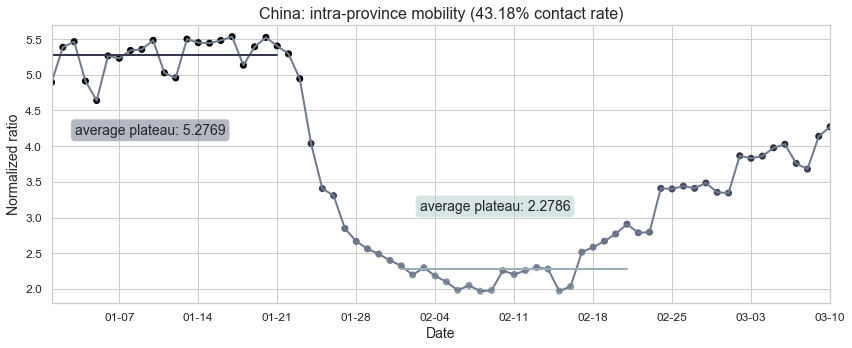

In [395]:
figure_intra_single(data_if_nation, 'China', 14)

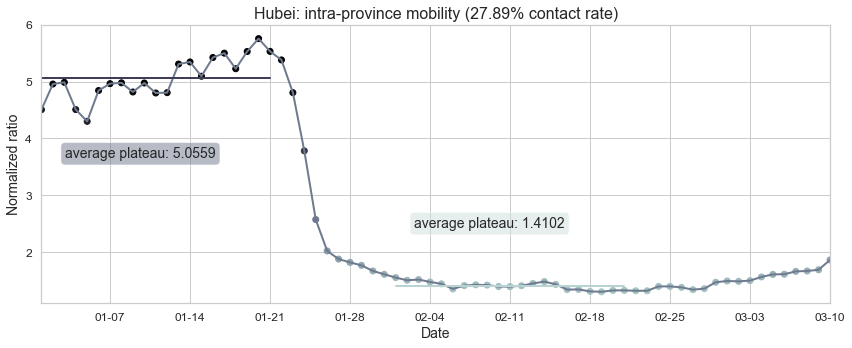

In [398]:
data_if_Hubei = data_if[data_if['province_name_en'] == 'Hubei']
data_if_Hubei = data_if_Hubei.reset_index(drop = True)
figure_intra_single(data_if_Hubei, 'Hubei', 14)

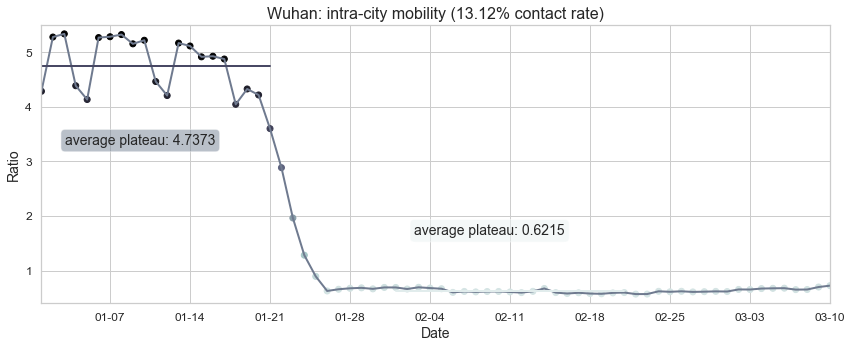

In [399]:
data_if_Wuhan = data_if_city[data_if_city['city_name'] == '武汉市']
data_if_Wuhan = data_if_Wuhan.reset_index(drop = True)
data_if_Wuhan['n_value'] = data_if_Wuhan['ratio']
figure_intra_single(data_if_Wuhan, 'Wuhan', 14)

In [400]:
# Plot the internal flow index: provincial (every province)
def figure_intra(df, date_initial, date_tr, ms, fsize, fs, title, country):
    
    temp = df[(df['update_date'] >= date_initial) & (df['update_date'] <= date_tr)].copy()
    # capital
    temp_beijing = temp[temp['province_name_en'] == 'Beijing']
    temp_beijing = temp_beijing.reset_index(drop = True)
    
    # last year
    temp_last = df[(df['update_date'] >= date_sp_2019 - date_sp_2020 + date_initial) & (df['update_date'] <= date_sp_2019 - date_sp_2020 + date_tr)].copy()
    # capital
    temp_beijing_last = temp_last[temp_last['province_name_en'] == 'Beijing']
    temp_beijing_last = temp_beijing_last.reset_index(drop = True)
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("whitegrid")
    palette = tealrose
    palette = [item for item in palette for j in range(int(len(names_province)/len(palette)) + 1)]
    
    for i, key in enumerate(names_province):
        grp = temp[temp['province_name_en'] == key].copy()
        grp = grp.reset_index(drop=True)
        grp_last = temp_last[temp_last['province_name_en'] == key].copy()
        grp_last = grp_last.reset_index(drop=True)
        if key =='Hubei':
            corr = grp['n_value'].corr(temp_beijing['n_value'])
            corr_last = grp_last['n_value'].corr(temp_beijing_last['n_value'])
            ax.plot(grp['update_date'], grp['n_value'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key + ': ' + str(round(corr,2)) + ' (' + str(round(corr_last, 2)) + ')')
        elif key == 'Beijing':
            ax.plot(grp['update_date'], grp['n_value'], linewidth = 1.5, marker = 'o', ms = ms, color = palette[i], label = key)
        else:
            corr = grp['n_value'].corr(temp_beijing['n_value'])
            corr_last = grp_last['n_value'].corr(temp_beijing_last['n_value'])
            ax.plot(grp['update_date'], grp['n_value'], linewidth = 1.5, color = palette[i], label = key + ': ' + str(round(corr,2)) + ' (' + str(round(corr_last, 2)) + ')')
            
    plt.legend(loc='upper center', ncol = 4, fancybox = True, handlelength = 1, fontsize = fs - 5)
    ax.set_xlabel("Date", fontsize = fs - 2)
    ax.set_ylabel("Normalized ratio", fontsize = fs - 2)
    ax.set_title('China: intra-province mobility', fontsize = fs)
    ax.set_xlim(min(temp.update_date), max(temp.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_intra_province.png', dpi = 400)
    plt.show()

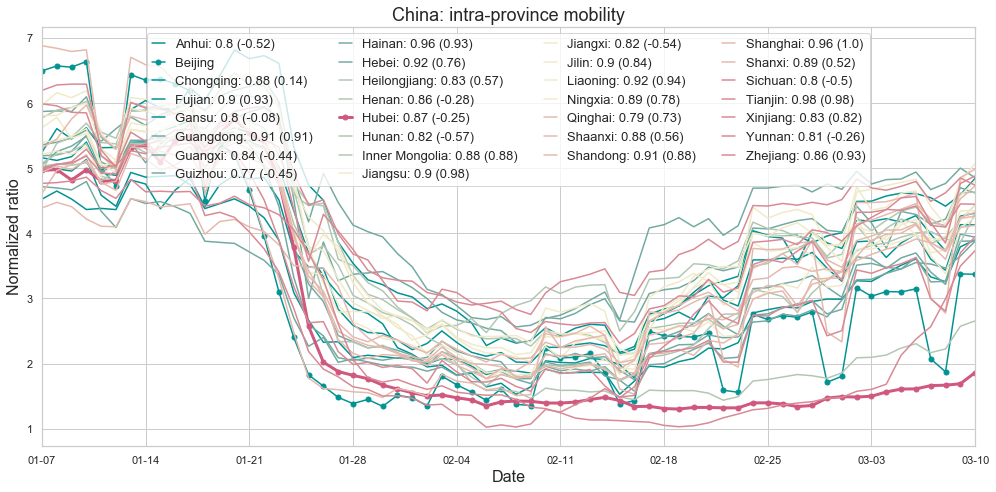

In [401]:
figure_intra(data_if, datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
          ms = 5, fsize = (14, 7), fs = 18, title = None, country = 'China')

In [406]:
def figure_intra_city_single(df_city, df_province, province, date_initial, date_tr, ms, fsize, fs, title, country):
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("whitegrid")
    palette_o = tealrose
    palette = tealrose
    
    temp = df_province[(df_province['province_name_en'] == province) & (df_province['update_date'] >= date_initial) & (df_province['update_date'] <= date_tr)].copy()
    temp['city_name'] = temp['province_name']
    temp = temp[['city_name', 'update_date', 'n_value', 'province_name', 'province_name_en', 'population', 'value']]
    temp = temp.rename(columns = {'n_value': 'ratio'}, inplace = False)
    temp_city = df_city[(df_city['province_name_en'] == province) & (df_city['update_date'] >= date_initial) & (df_city['update_date'] <= date_tr)].copy()
    temp_city = temp_city.append(temp)
    temp_city = temp_city.dropna()
    temp_city = temp_city.sort_values(by=['update_date', 'population'])
    temp_city = temp_city.reset_index(drop = True)
    names_city = list(dict.fromkeys(temp_city['city_name']))
    # capital city
    temp_capital = temp_city[temp_city['city_name'] == provincial_capital_dict_cn[province]]
    temp_capital = temp_capital.reset_index(drop = True)
    
    # last year
    temp_city_last = df_city[(df_city['province_name_en'] == province) & (df_city['update_date'] >= date_sp_2019 - date_sp_2020 + date_initial) & (df_city['update_date'] <= date_sp_2019 - date_sp_2020 + date_tr)].copy()
    temp_city_last = temp_city_last.dropna()
    temp_city_last = temp_city_last.sort_values(by=['update_date', 'population'])
    temp_city_last = temp_city_last.reset_index(drop = True)
    # capital city
    temp_capital_last = temp_city_last[temp_city_last['city_name'] == provincial_capital_dict_cn[province]]
    temp_capital_last = temp_capital_last.reset_index(drop = True)
    
    
    palette = [item for item in palette for j in range(int(len(names_city)/len(palette)) + 1)]
    #if len(palette) < len(names_city):
        #palette += [palette_o[-1]]*(len(names_city) - len(palette))

    for j, key in enumerate(names_city):
        grp = temp_city[temp_city['city_name'] == key].copy()
        grp = grp.reset_index(drop = True)
        # last year
        grp_last = temp_city_last[temp_city_last['city_name'] == key].copy()
        grp_last = grp_last.reset_index(drop = True)
        if key == temp['province_name'].tolist()[0]:
            ax.plot(grp['update_date'], grp['ratio'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key)
        elif key == provincial_capital_dict_cn[province]:
            ax.plot(grp['update_date'], grp['ratio'], linewidth = 1.5, marker = 'o', ms = ms, color = palette[j], label = key)
        else:
            corr = grp['ratio'].corr(temp_capital['ratio'])
            corr_last = grp_last['ratio'].corr(temp_capital_last['ratio'])
            ax.plot(grp['update_date'], grp['ratio'], linewidth = 1.5, color = palette[j], label = key + ': ' + str(round(corr,2)) + ' (' + str(round(corr_last, 2)) + ')')

    font_chinese.set_size(fs - 4)
    #ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol = 1, fancybox = True, handlelength = 2, prop = font_chinese)
    ax.legend(loc='upper center', ncol = 4, fancybox = True, handlelength = 1, prop = font_chinese)
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('(Normalized) Ratio', fontsize = fs - 2)
    ax.set_title(temp['province_name_en'].tolist()[0] + ': intra-city mobility', fontsize = fs, y = 1.01)
    ax.set_xlim(min(temp.update_date), max(temp.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 5)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 5)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + province + '_intra_city.png', dpi = 400, bbox_inches='tight')   
    

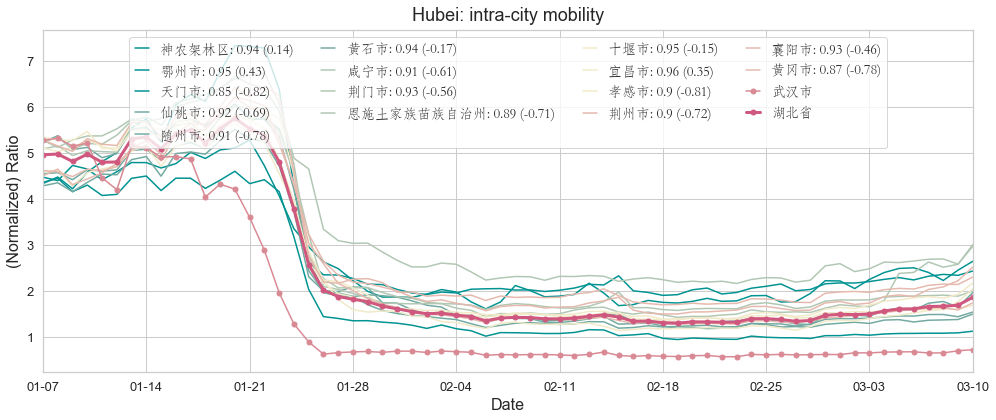

In [407]:
figure_intra_city_single(data_if_city, data_if, 'Hubei', 
                      datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
                      ms = 5, fsize = (14, 6), fs = 18, title = None, country = 'China')


In [408]:
def figure_intra_city(df_city, df_province, names_province, date_initial, date_tr, 
                   ncol = 3, ms = 2, fsize = (5, 3), fs = 10, title = None, country = 'China'):
    
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.025)
    sns.set_style("whitegrid")
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    palette_o = tealrose
    
    font_chinese.set_size(fs - 12)
    
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        
        temp = df_province[(df_province['province_name_en'] == province) & (df_province['update_date'] >= date_initial) & (df_province['update_date'] <= date_tr)].copy()
        temp['city_name'] = temp['province_name']
        temp = temp[['city_name', 'update_date', 'n_value', 'province_name', 'province_name_en', 'population', 'value']]
        temp = temp.rename(columns = {'n_value': 'ratio'}, inplace = False)
        
        if province in ['Beijing', 'Chongqing', 'Shanghai', 'Tianjin']:
            axes[ix].plot(temp['update_date'], temp['ratio'], linewidth = 2, marker = 'o', ms = ms, color = palette_o[-1], label = str())       
        else:
            temp_city = df_city[(df_city['province_name_en'] == province) & (df_city['update_date'] >= date_initial) & (df_city['update_date'] <= date_tr)].copy()

            temp_city = temp_city.append(temp)
            temp_city = temp_city.dropna()
            temp_city = temp_city.sort_values(by=['update_date', 'population'])
            temp_city = temp_city.reset_index(drop = True)
            names_city = list(dict.fromkeys(temp_city['city_name']))
            # capital city
            temp_capital = temp_city[temp_city['city_name'] == provincial_capital_dict_cn[province]]
            temp_capital = temp_capital.reset_index(drop = True)
            
            # last year
            temp_city_last = df_city[(df_city['province_name_en'] == province) & (df_city['update_date'] >= date_sp_2019 - date_sp_2020 + date_initial) & (df_city['update_date'] <= date_sp_2019 - date_sp_2020 + date_tr)].copy()
            temp_city_last = temp_city_last.dropna()
            temp_city_last = temp_city_last.sort_values(by=['update_date', 'population'])
            temp_city_last = temp_city_last.reset_index(drop = True)
            # capital city
            temp_capital_last = temp_city_last[temp_city_last['city_name'] == provincial_capital_dict_cn[province]]
            temp_capital_last = temp_capital_last.reset_index(drop = True)

            palette = tealrose
            palette = [item for item in palette for j in range(int(len(names_city)/len(palette) + 1))]
            if len(palette) < len(names_city):
                palette += [palette_o[-1]]*(len(names_city) - len(palette))
            
            for j, key in enumerate(names_city):
                grp = temp_city[temp_city['city_name'] == key].copy()
                grp = grp.reset_index(drop = True)
                # last year
                grp_last = temp_city_last[temp_city_last['city_name'] == key].copy()
                grp_last = grp_last.reset_index(drop = True)
                if key == temp['province_name'].tolist()[0]:
                    axes[ix].plot(grp['update_date'], grp['ratio'], linewidth = 3, marker = 'o', ms = ms, color = palette[-1], label = key)
                elif key == provincial_capital_dict_cn[province]:
                    axes[ix].plot(grp['update_date'], grp['ratio'], linewidth = 1.5, marker = 'o', ms = ms, color = palette[j], label = key)
                else:
                    corr = grp['ratio'].corr(temp_capital['ratio'])
                    corr_last = grp_last['ratio'].corr(temp_capital_last['ratio'])
                    axes[ix].plot(grp['update_date'], grp['ratio'], linewidth = 1.5, color = palette[j], label = key + ': ' + str(round(corr,2)) + ' (' + str(round(corr_last, 2)) + ')')
         
            axes[ix].legend(loc='upper center', ncol = 4, fancybox = True, handlelength = 1, prop = font_chinese)
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 10)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Ratio', fontsize = fs - 10)
            axes[ix].get_yaxis().set_label_coords(-0.05, 0.5)

        axes[ix].set_title(temp['province_name_en'].tolist()[0], fontsize = fs - 6)
        axes[ix].set_xlim(min(temp.update_date), max(temp.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 13)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 13)
        
    fig.align_ylabels(axes[:, 0])
    
    fig.suptitle('China: intra-province mobility', fontsize = fs + 8, y = 1.01)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_intra_city.png', dpi = 400, bbox_inches='tight')   

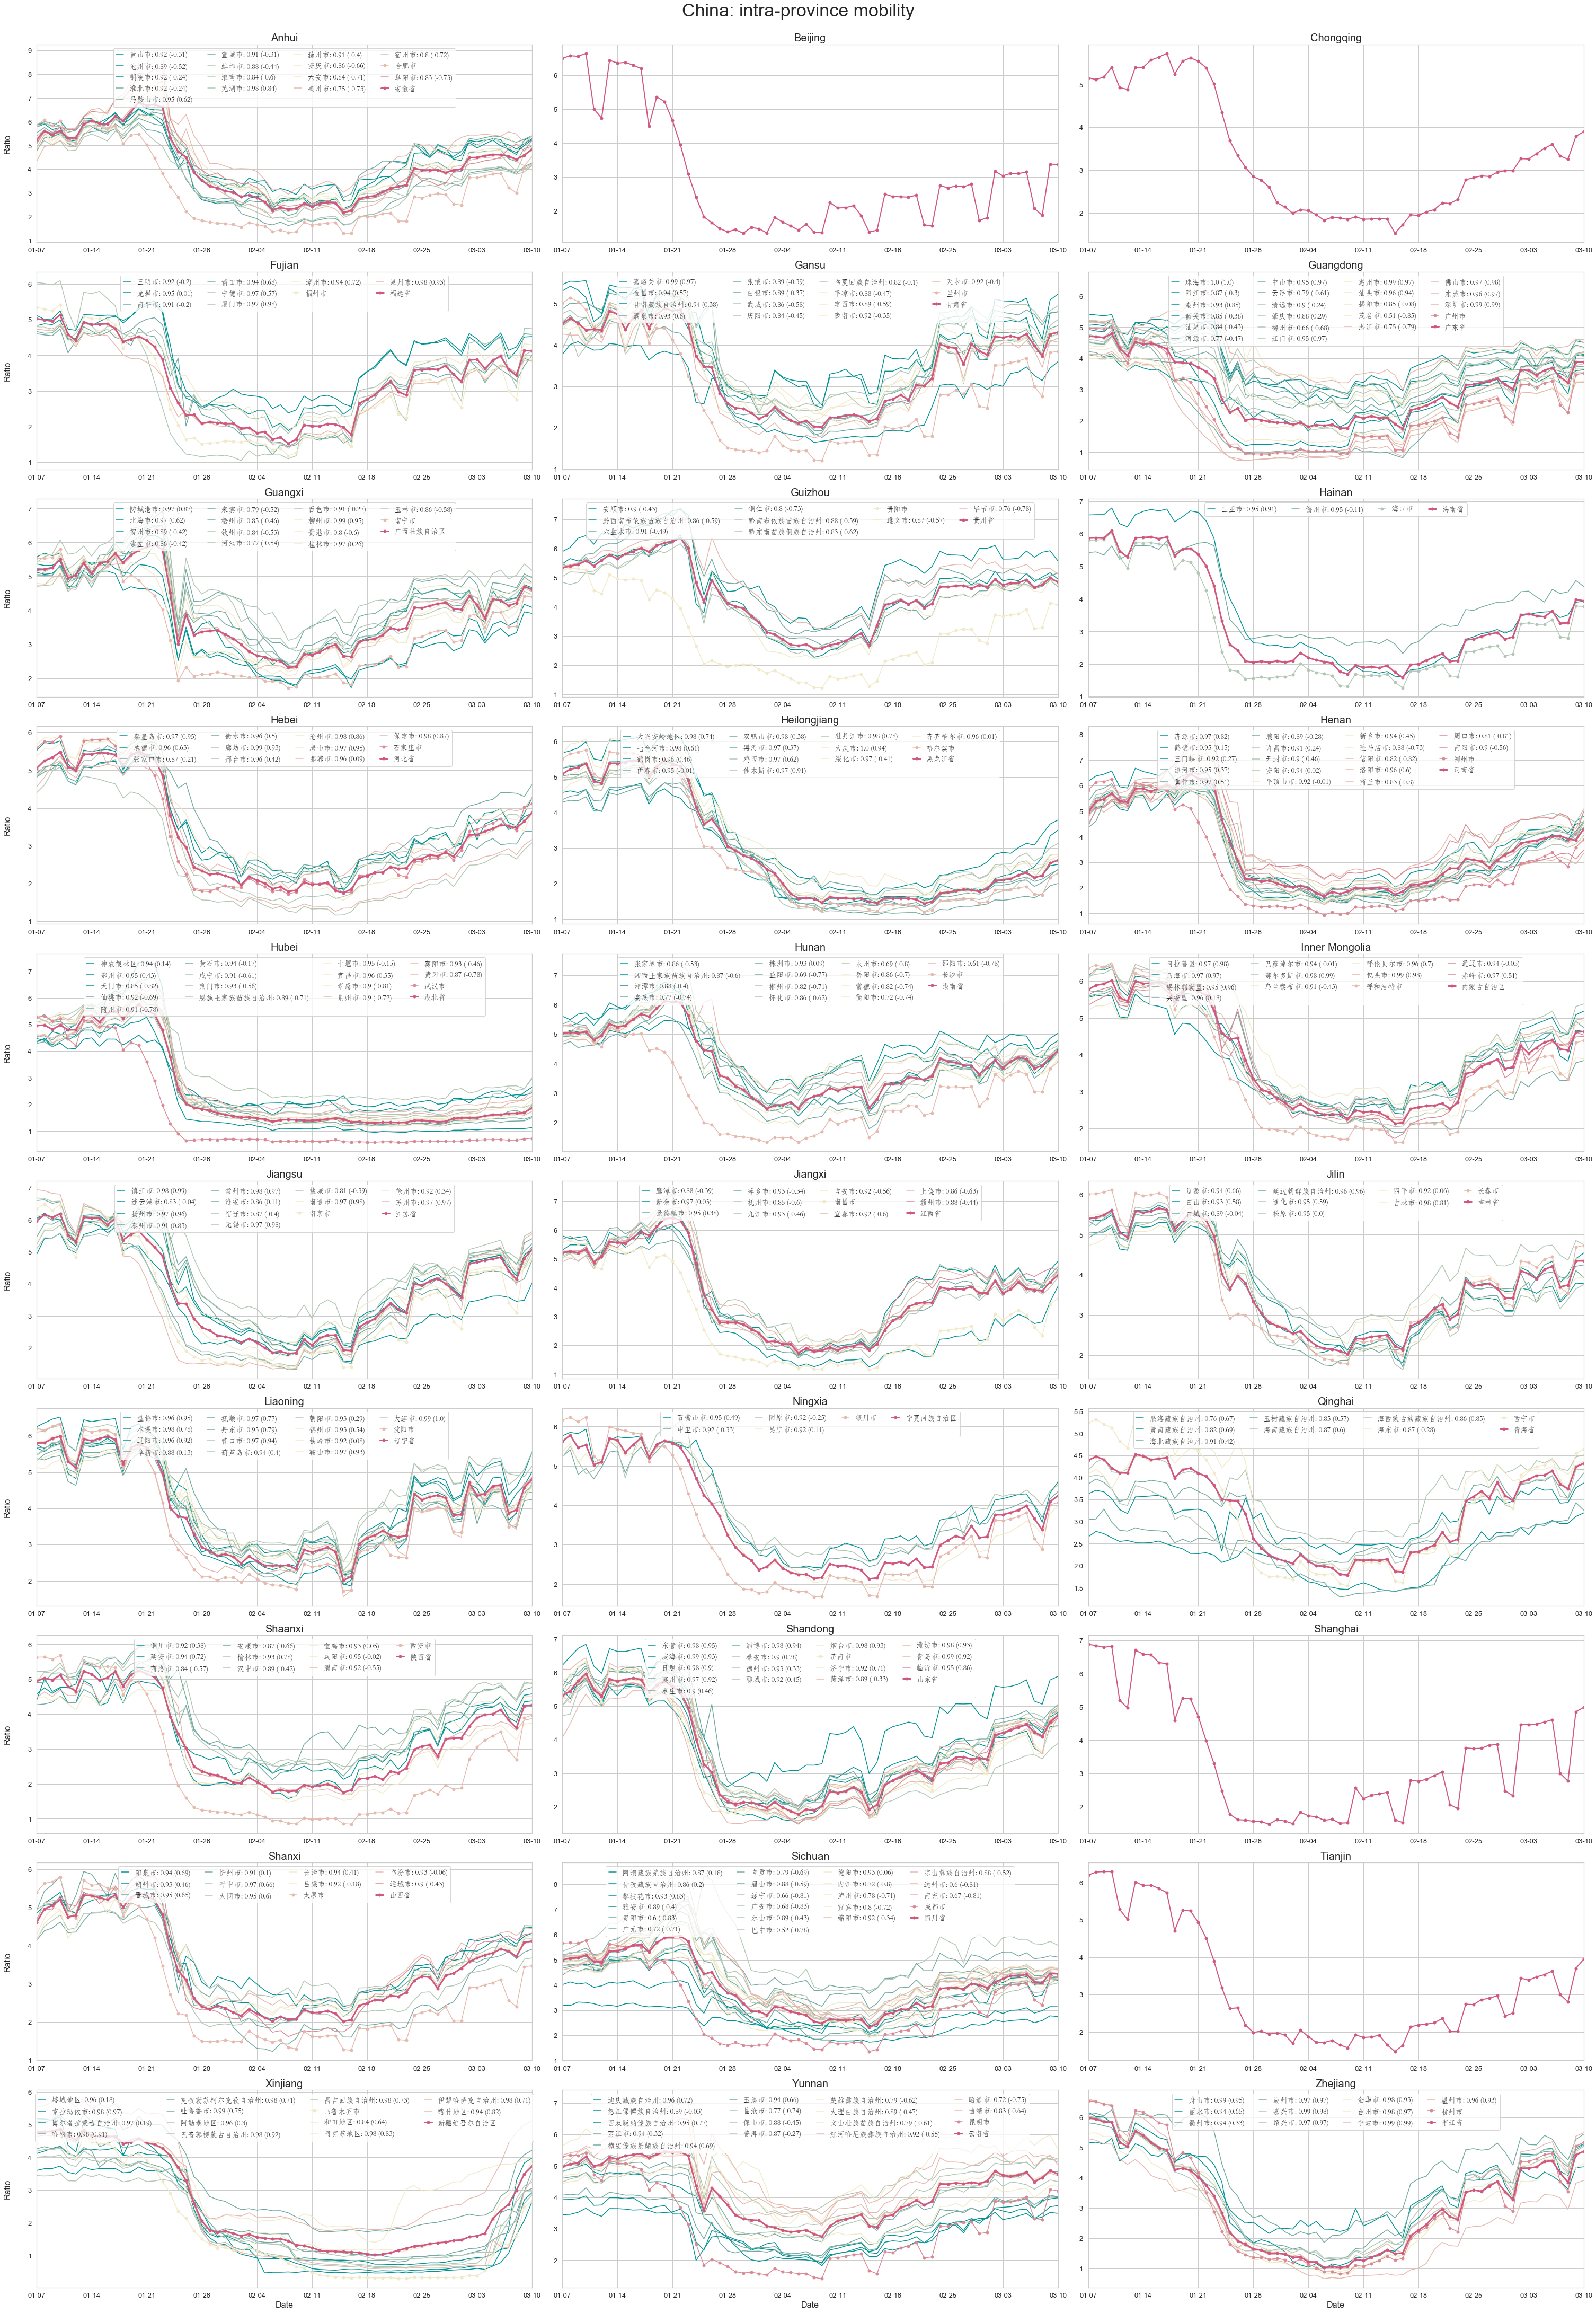

In [409]:
figure_intra_city(data_if_city, data_if, names_province, datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
               ncol = 3, ms = 5, fsize = (14, 6), fs = 26, title = None, country = 'China')

In [344]:
#data_if_single = data_if_city[data_if_city.update_date == datetime.date(int(2020),int(1),int(31))]
#data_if_single = data_if_single[data_if_single.province_name == '湖北省']
#data_if_single.sort_values(by = 'population')

In [345]:
data_city, data_province, data_province_domestic = load_DXY_raw()

In [346]:
def figure_mobility(df, df_intra, date_initial, date_tr, ncol, fsize, fs, title, country):
    
    fig, axes = plt.subplots(3, ncol, figsize=(3*fsize[0], 3*fsize[1]), sharex=True, sharey=True)
    fig.subplots_adjust(hspace = 0.15, wspace = 0.15)
    
    cbar_ax = fig.add_axes([1.02, 0.55, .02, .4])
    cbar_intra_ax = fig.add_axes([1.02, 0.1, .02, .4])
    date_initial = datetime.date(int(2020),int(1),int(7))
    palette = tealrose
    colors = [[np.power(i/(len(palette) - 1), np.e), palette[i]] for i in range(0, len(palette))]
    cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    value_min = df[df['update_date'] >= date_initial]['value'].min()
    value_max = df[df['update_date'] >= date_initial]['value'].max()
    value_intra_min = df_intra[df_intra['update_date'] >= date_initial]['n_value'].min()
    value_intra_max = df_intra[df_intra['update_date'] >= date_initial]['n_value'].max()

    #norm = plt.Normalize(value_min, value_max)
    for i, ax in enumerate(axes.flat):
        date_current = date_initial + timedelta(days=i*7)
        temp = df[df['update_date'] == date_current].copy()
        temp_wide = temp.pivot_table(index = 'source_en', columns = 'target_en', values = 'value')
        temp_intra = df_intra[df_intra['update_date'] == date_current].copy()
        temp_intra['province_name'] = temp_intra['province_name_en']
        temp_intra_wide = temp_intra.pivot_table(index = 'province_name_en', columns = 'province_name', values = 'n_value')
        
        # reorder
        data_single = data_province_domestic[data_province_domestic.update_date == date_tr].copy()
        data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
        data_single = data_single.reset_index(drop = True)
        provinces = data_single['province_name_en'].tolist()
        temp_wide = temp_wide.reindex(provinces)[provinces]
        temp_intra_wide = temp_intra_wide.reindex(provinces)[provinces]
        im = sns.heatmap(temp_wide, ax = ax, linewidths = 1, linecolor = 'white', cmap = cmap, 
                         vmin = value_min, vmax = value_max,
                         cbar = i == 0, cbar_ax = None if i else cbar_ax, cbar_kws={'label': 'inter'})
        cbar_ax.yaxis.label.set_size(fs) # colorbar label
        im_intra = sns.heatmap(temp_intra_wide, ax = ax, linewidths = 1, linecolor = 'white', cmap = 'bone_r', 
                              vmin = value_intra_min, vmax = value_intra_max, 
                               cbar = i == 0, cbar_ax = None if i else cbar_intra_ax, cbar_kws={'label': 'intra'})
        cbar_intra_ax.yaxis.label.set_size(fs) # colorbar label
        ax.invert_xaxis()
        
        if i >= 2*ncol:
            ax.set_xlabel('Target', fontsize = fs - 4)
        else:
            ax.set_xlabel('')

        if i % ncol == 0:
            ax.set_ylabel('Source', fontsize = fs - 4)
        else:
            ax.set_ylabel('')

        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 16)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 16)        

        ax.set_title(date_current, fontsize = fs)
        
        if i == 0:
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize = fs)
            
            cbar = ax.collections[1].colorbar
            cbar.ax.tick_params(labelsize = fs)
            
            cbar_ax.get_yaxis().set_label_coords(2.5,0.5)
            cbar_intra_ax.get_yaxis().set_label_coords(2.5,0.5)
            

    fig.suptitle('China: mobility', fontsize = fs + 10, y = 1.03)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_mobility_heatmap.png', dpi = 400, bbox_inches='tight') 
    
    return temp_intra_wide


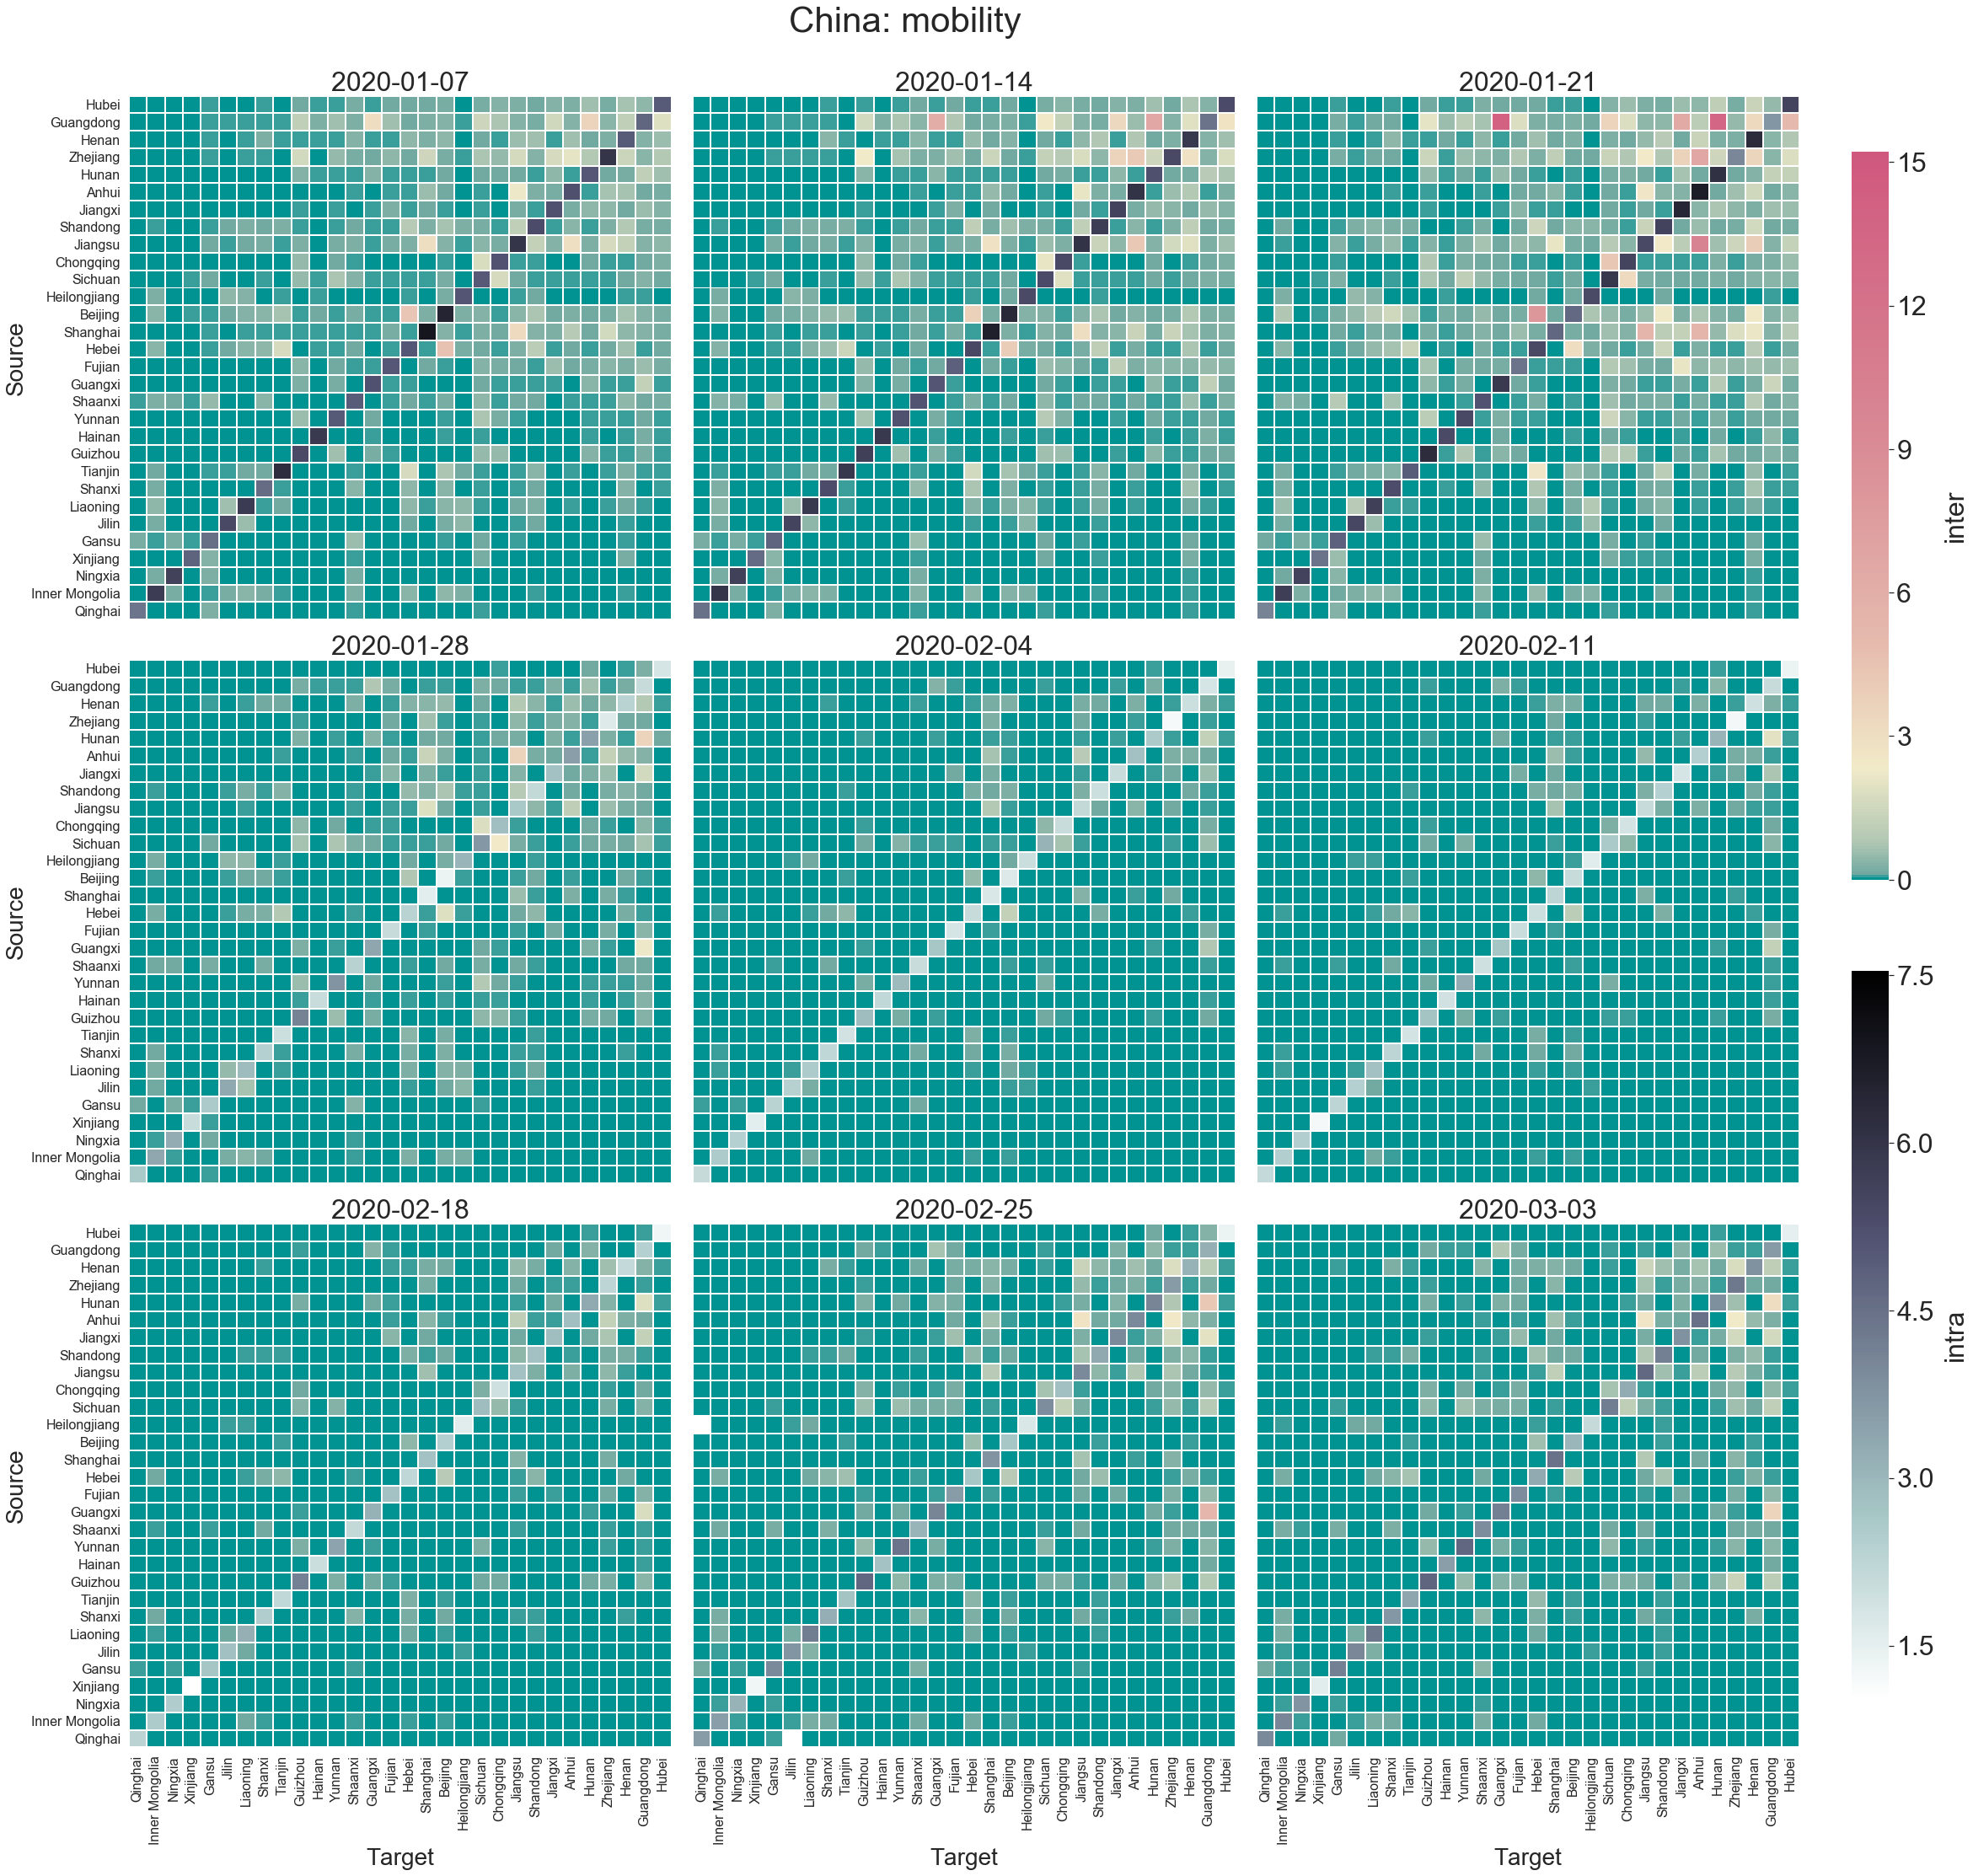

In [347]:
temp_intra_wide = figure_mobility(data_network_P2P, data_if, 
                                  datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
                3, fsize = (10, 10), fs = 32, title = None, country = 'China')

In [348]:
def figure_mobility_single(df, df_intra, date_initial, date_current, date_tr, fsize, fs, title, country):
    
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("whitegrid")
    
    cbar_ax = fig.add_axes([1.01, 0.55, .02, .35])
    cbar_intra_ax = fig.add_axes([1.01, 0.15, .02, .35])
    palette = tealrose
    colors = [[np.power(i/(len(palette) - 1), np.e), palette[i]] for i in range(0, len(palette))]
    cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    value_min = df[df['update_date'] >= date_initial]['value'].min()
    value_max = df[df['update_date'] >= date_initial]['value'].max()
    value_intra_min = df_intra[df_intra['update_date'] >= date_initial]['n_value'].min()
    value_intra_max = df_intra[df_intra['update_date'] >= date_initial]['n_value'].max()
    
    temp = df[df['update_date'] == date_current].copy()
    temp_wide = temp.pivot_table(index = 'source_en', columns = 'target_en', values = 'value')
    temp_intra = df_intra[df_intra['update_date'] == date_current].copy()
    temp_intra['province_name'] = temp_intra['province_name_en']
    temp_intra_wide = temp_intra.pivot_table(index = 'province_name_en', columns = 'province_name', values = 'n_value')

    # reorder
    data_single = data_province_domestic[data_province_domestic.update_date == date_tr].copy()
    data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
    data_single = data_single.reset_index(drop = True)
    provinces = data_single['province_name_en'].tolist()
    
    temp_wide = temp_wide.reindex(provinces)[provinces]
    temp_intra_wide = temp_intra_wide.reindex(provinces)[provinces]
    
    
    im = sns.heatmap(temp_wide, ax = ax, linewidths = 1, linecolor = 'white', cmap = cmap, 
                     vmin = value_min, vmax = value_max,
                     cbar_ax = cbar_ax, cbar_kws={'label': 'inter'})
    cbar_ax.yaxis.label.set_size(fs - 2) # colorbar label
    im_intra = sns.heatmap(temp_intra_wide, ax = ax, linewidths = 1, linecolor = 'white', cmap = 'bone_r', 
                           vmin = value_intra_min, vmax = value_intra_max, 
                           cbar_ax = cbar_intra_ax, cbar_kws={'label': 'intra'})
    cbar_intra_ax.yaxis.label.set_size(fs - 2) # colorbar label
    ax.invert_xaxis()
        

    ax.set_xlabel('Target', fontsize = fs)
    ax.set_ylabel('Source', fontsize = fs)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 6)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 6)  

    cbar_ax.get_yaxis().set_label_coords(3,0.5)
    cbar_intra_ax.get_yaxis().set_label_coords(3,0.5)
    
    ax.set_title('China: mobility (' + str(date_current) + ')', fontsize = fs + 2)

    

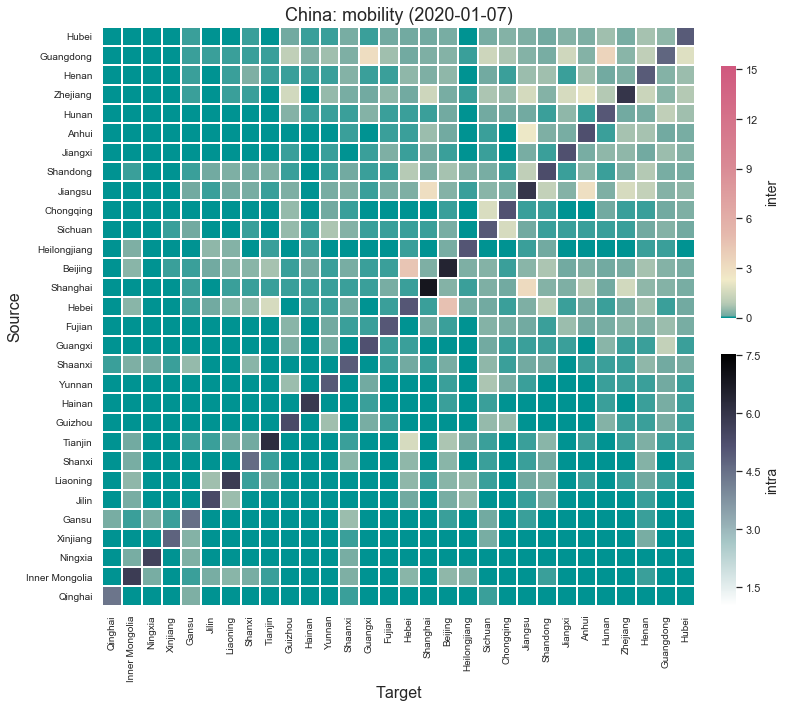

In [349]:
figure_mobility_single(data_network_P2P, data_if, 
                       datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(1),int(7)), datetime.date(int(2020),int(3),int(10)), 
                       (10, 10), 16, None, 'China')

In [350]:
temp = data_network_P2P[data_network_P2P['update_date'] == datetime.date(int(2020),int(1),int(7))]
temp[temp['source_en'].isin(['Guangdong', 'Hubei']) & temp['target_en'].isin(['Guangdong', 'Hubei'])]

update_date source  source_en target  target_en     value
5558  2020-01-07    广东省  Guangdong    湖北省      Hubei  1.860608
5811  2020-01-07    湖北省      Hubei    广东省  Guangdong  0.427260